In [53]:
%matplotlib inline

# useful packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [54]:
# Generating the system

N = 3
G1 = nx.grid_2d_graph(N,N)
pos = dict( (n, n) for n in G1.nodes() )
labels = dict( ((i, j), i * N + j) for i, j in G1.nodes() )

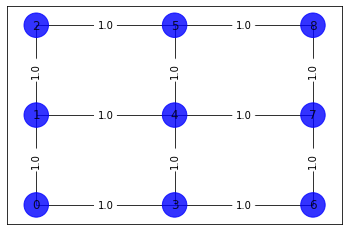

In [55]:
# Transform to weighted graph:
n = N**2
V = np.arange(0, N, 1)

E =[]

tuples = []
other_tup = []
point_edge_map = []
other_map = []
relations = []

for edge in G1.edges:
    point1 = edge[0]
    strpoint1 = str(point1[0]) + str(point1[1])
    point2 = edge[1]
    strpoint2 = str(point2[0]) + str(point2[1])
    if not strpoint1 in point_edge_map:
        point_edge_map.append(strpoint1)
        tuples.append(edge[0])
    if not strpoint2 in other_map:
        other_map.append(strpoint2)
        other_tup.append(edge[1])
    relations.append((strpoint1, strpoint2))

tuples.append(other_tup[len(other_tup) - 1])
point_edge_map.append(other_map[len(other_map) - 1])

dic = {}
for i in range(len(point_edge_map)):
    dic[i] = point_edge_map[i]
    
point_edge_map = np.array(point_edge_map)
relations = np.array(relations)

for relation in relations:
    ver1 = relation[0]
    ver2 = relation[1]
    point1 = np.where(point_edge_map == ver1)[0][0]
    point2 = np.where(point_edge_map == ver2)[0][0]
    edge = (point1, point2, 1.0)
    E.append(edge)
    
G = nx.Graph()

G.add_nodes_from(V)

G.add_weighted_edges_from(E)

colors = ["b" for node in G.nodes()]
pos = dict()
for i in range(n):
    pos[i] = tuples[i]

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [56]:
# Matrix Representation of Graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]

print(w)

[[0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0.]]


## Classical (Brute Force) Approach

In [57]:
%%time

best_cost_brute = 0
config = []
costs = []
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j] * x[i] * (1 - x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    config.append((x, ))
    costs.append(cost)
    # print("case = " + str(x) + " cost = " + str(cost))

# choose the more stable configuration
E = []
low_ind = np.argwhere(costs == np.amax(costs)).flatten()
for i in range(len(low_ind)):
    E.append(sum(config[low_ind[i]][0]))
min_loc = np.argmin(E)
xbest_brute = config[low_ind[min_loc]][0]

print("\nBest solution = " + str(xbest_brute) + " cost = " + str(best_cost_brute))


Best solution = [0, 1, 0, 1, 0, 1, 0, 1, 0] cost = 12.0
CPU times: user 40.7 ms, sys: 1.64 ms, total: 42.4 ms
Wall time: 41.1 ms


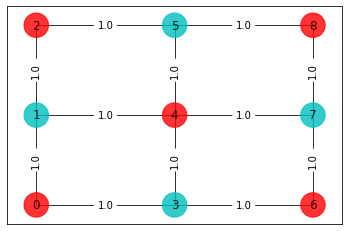

In [58]:
# red = spin down, blue = spin up
colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

### Mapping to the Ising problem

Qiskit provides functionality to generate `QuadraticProgram` from the problem specification as well as create the corresponding Ising Hamiltonian.

In [59]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_1*x_4 - 2*x_2*x_5 - 2*x_3*x_4
  - 2*x_3*x_6 - 2*x_4*x_5 - 2*x_4*x_7 - 2*x_5*x_8 - 2*x_6*x_7 - 2*x_7*x_8
  + 2*x_0 + 3*x_1 + 2*x_2 + 3*x_3 + 4*x_4 + 3*x_5 + 2*x_6 + 3*x_7 + 2*x_8

Subject to
  No constraints

  Binary variables (9)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8



In [50]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -6.0
Ising Hamiltonian:
0.5 * IIIIIIIZZ
+ 0.5 * IIIIIIZZI
+ 0.5 * IIIIIZIIZ
+ 0.5 * IIIIZIIZI
+ 0.5 * IIIIZZIII
+ 0.5 * IIIZIIZII
+ 0.5 * IIIZZIIII
+ 0.5 * IIZIIZIII
+ 0.5 * IZIIZIIII
+ 0.5 * IZZIIIIII
+ 0.5 * ZIIZIIIII
+ 0.5 * ZZIIIIIII


In [51]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 12.0
variable values: x_0=0.0, x_1=1.0, x_2=0.0, x_3=1.0, x_4=0.0, x_5=1.0, x_6=0.0, x_7=1.0, x_8=0.0
status: SUCCESS


### Checking that the full Hamiltonian gives the right cost 

energy: -6.0
max-cut objective: -12.0
solution: [0 1 0 1 0 1 0 1 0]
solution objective: 12.0


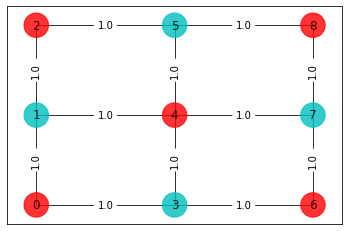

In [52]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [13]:
# Check backends
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator'),
 PulseSimulator('pulse_simulator')]

In [14]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -5.669921875000001
time: 14.487360954284668
max-cut objective: -11.669921875
solution: [1 0 1 0 1 0 1 0 1]
solution objective: 12.0


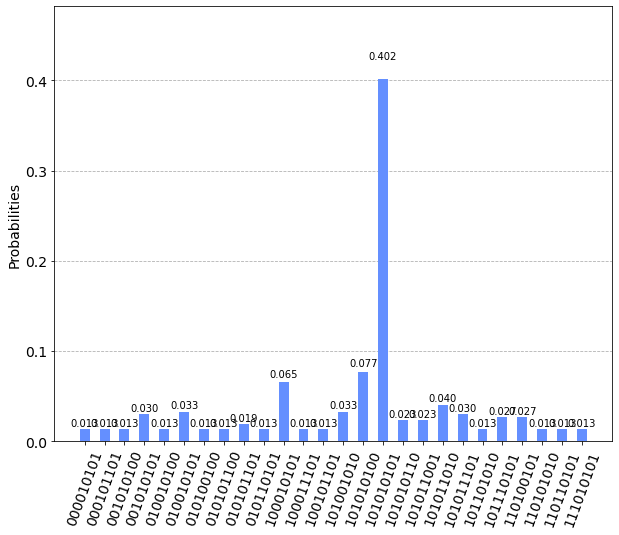

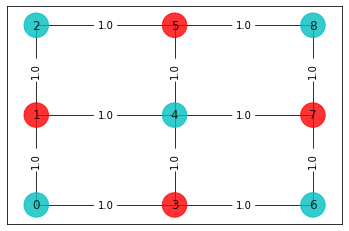

In [28]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)
plot_histogram(result.eigenstate, figsize = (10,8), bar_labels = True)

Trial 0:
energy: -5.672851562499999
time: 13.614965915679932
max-cut objective: -11.6728515625
solution: [0 1 0 1 0 1 0 1 0]
solution objective: 12.0

Trial 1:
energy: -5.754882812500003
time: 13.57125997543335
max-cut objective: -11.754882812500004
solution: [1 0 1 0 1 0 1 0 1]
solution objective: 12.0

Trial 2:
energy: -5.937499999999997
time: 11.741306781768799
max-cut objective: -11.937499999999996
solution: [0 1 0 1 0 1 0 1 0]
solution objective: 12.0

Trial 3:
energy: -5.3779296875
time: 15.548665046691895
max-cut objective: -11.3779296875
solution: [1 0 1 0 1 0 1 0 1]
solution objective: 12.0

Trial 4:
energy: -5.465820312499999
time: 14.376466274261475
max-cut objective: -11.4658203125
solution: [1 0 1 0 1 0 1 0 1]
solution objective: 12.0

Trial 5:
energy: -5.957031250000003
time: 12.133243799209595
max-cut objective: -11.957031250000004
solution: [1 0 1 0 1 0 1 0 1]
solution objective: 12.0

Trial 6:
energy: -5.69140625
time: 12.689889192581177
max-cut objective: -11.69140625

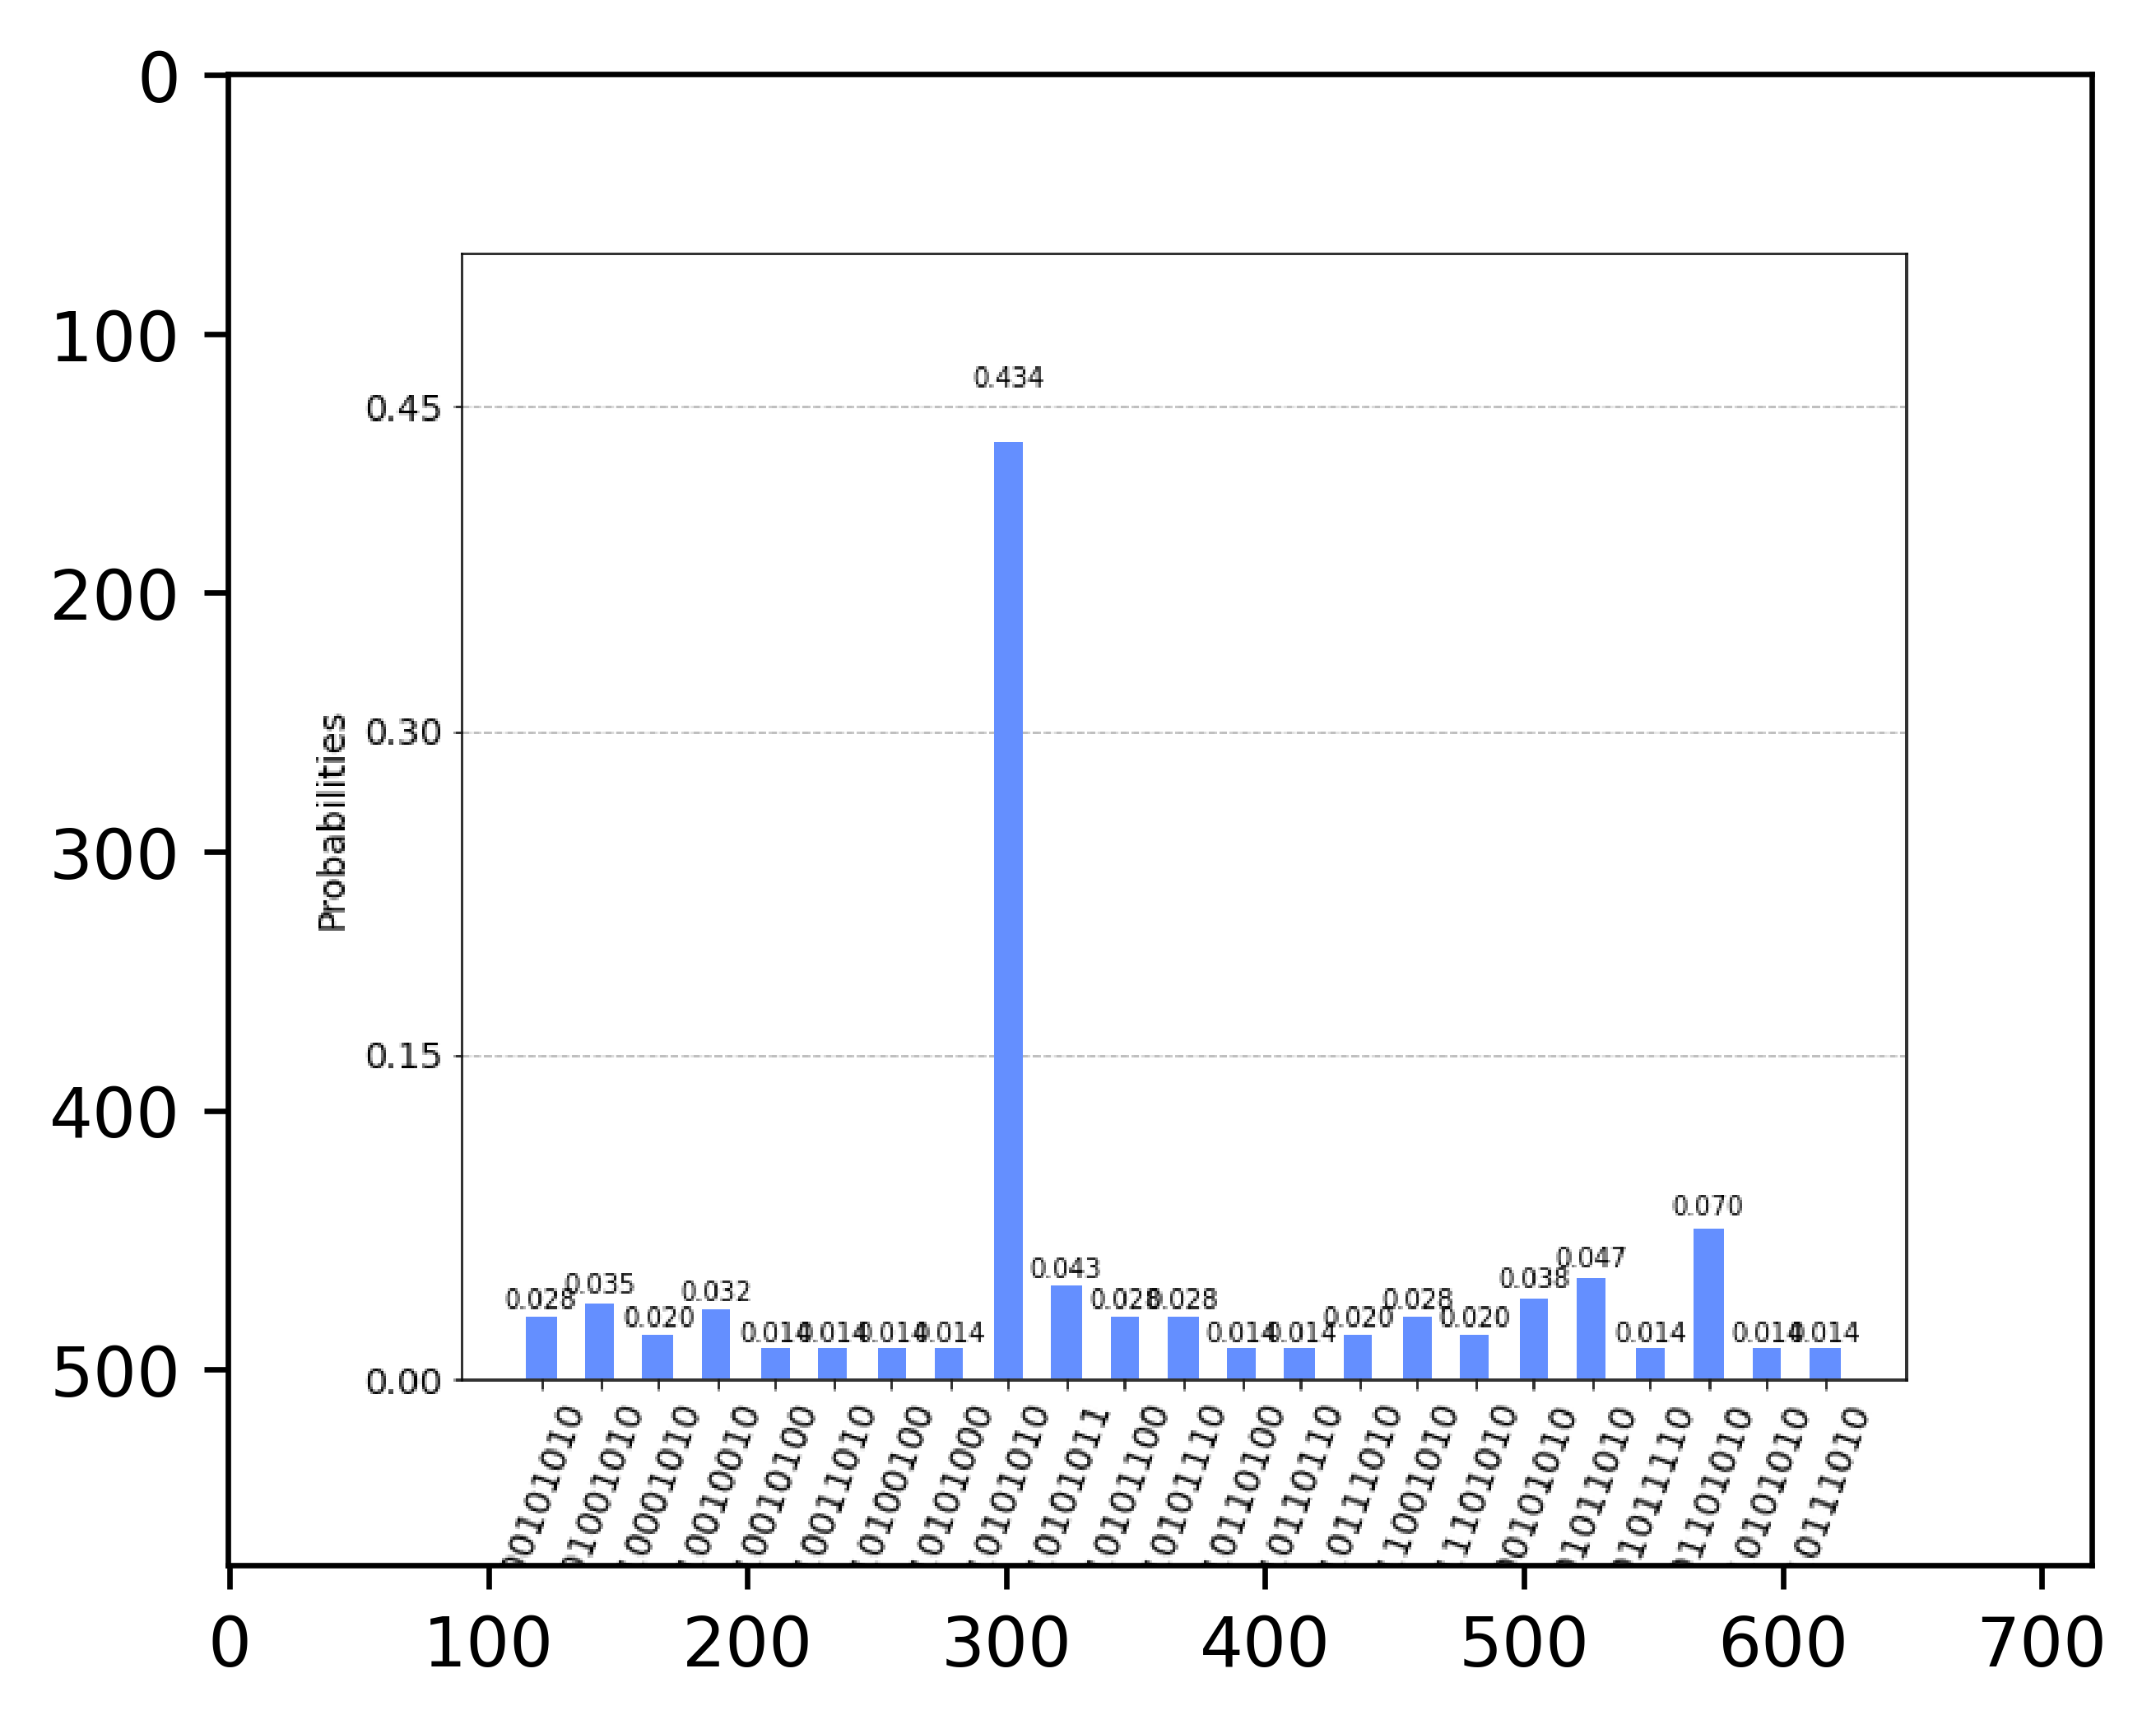

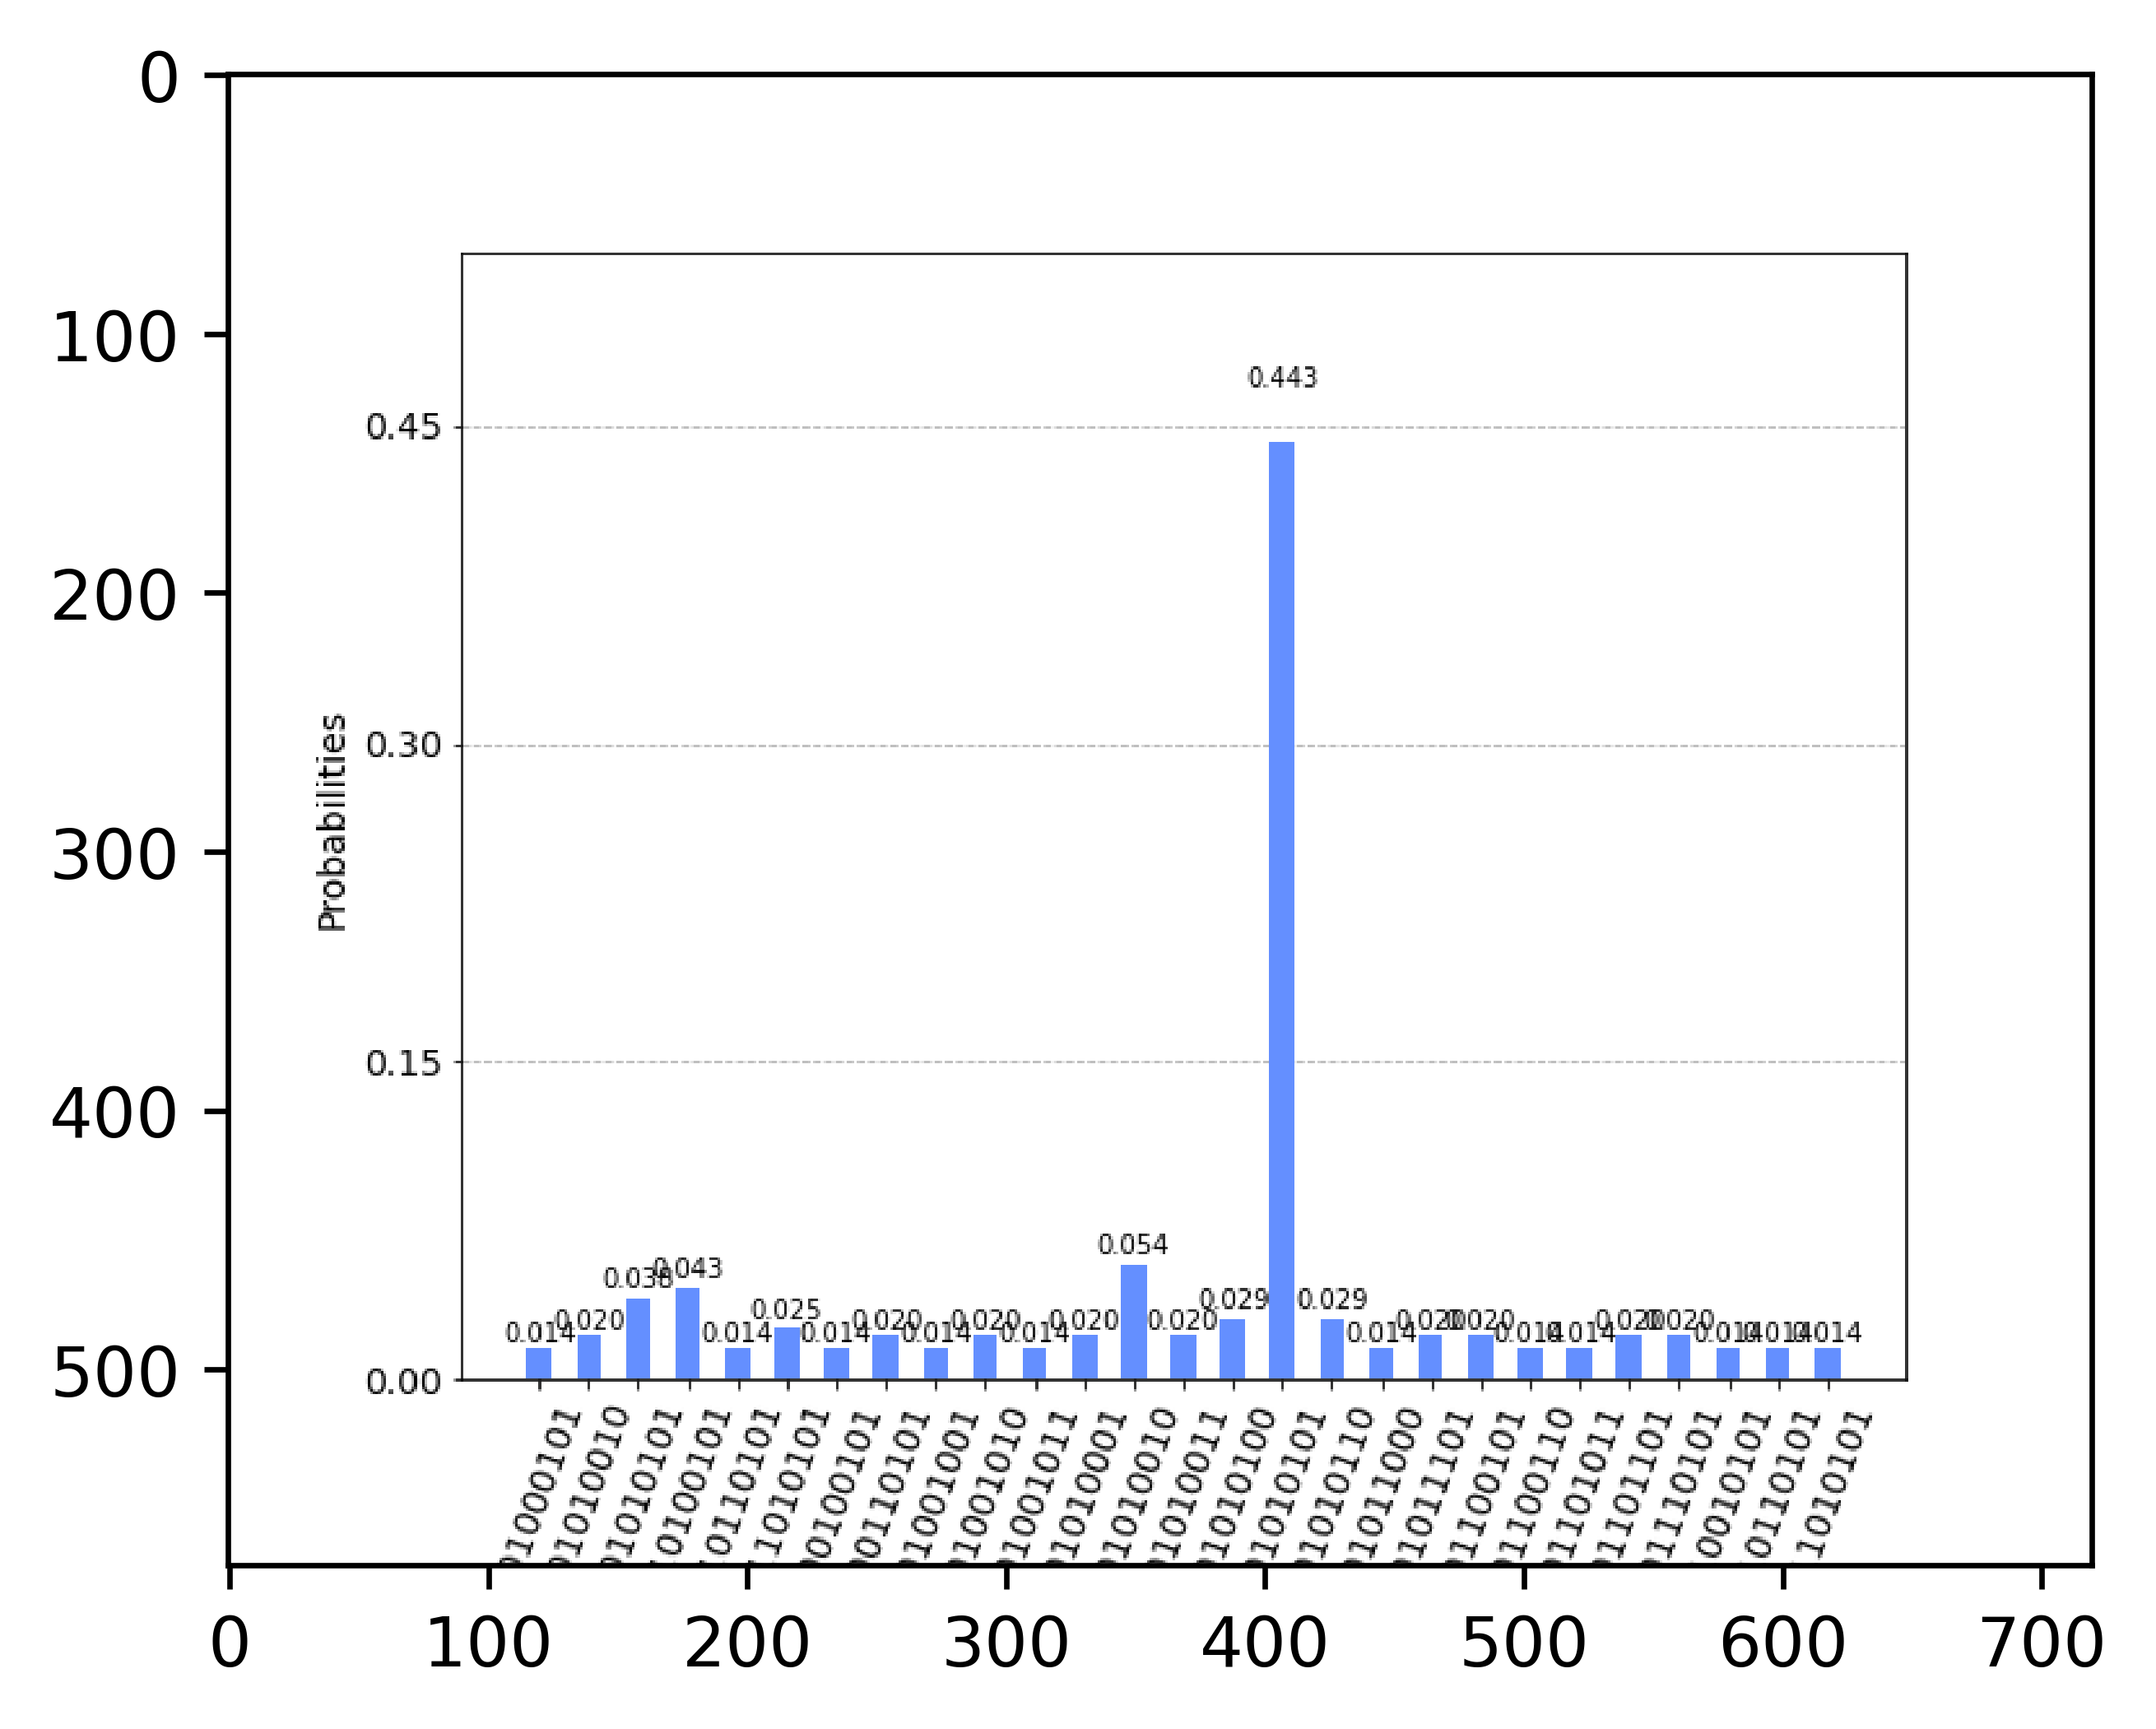

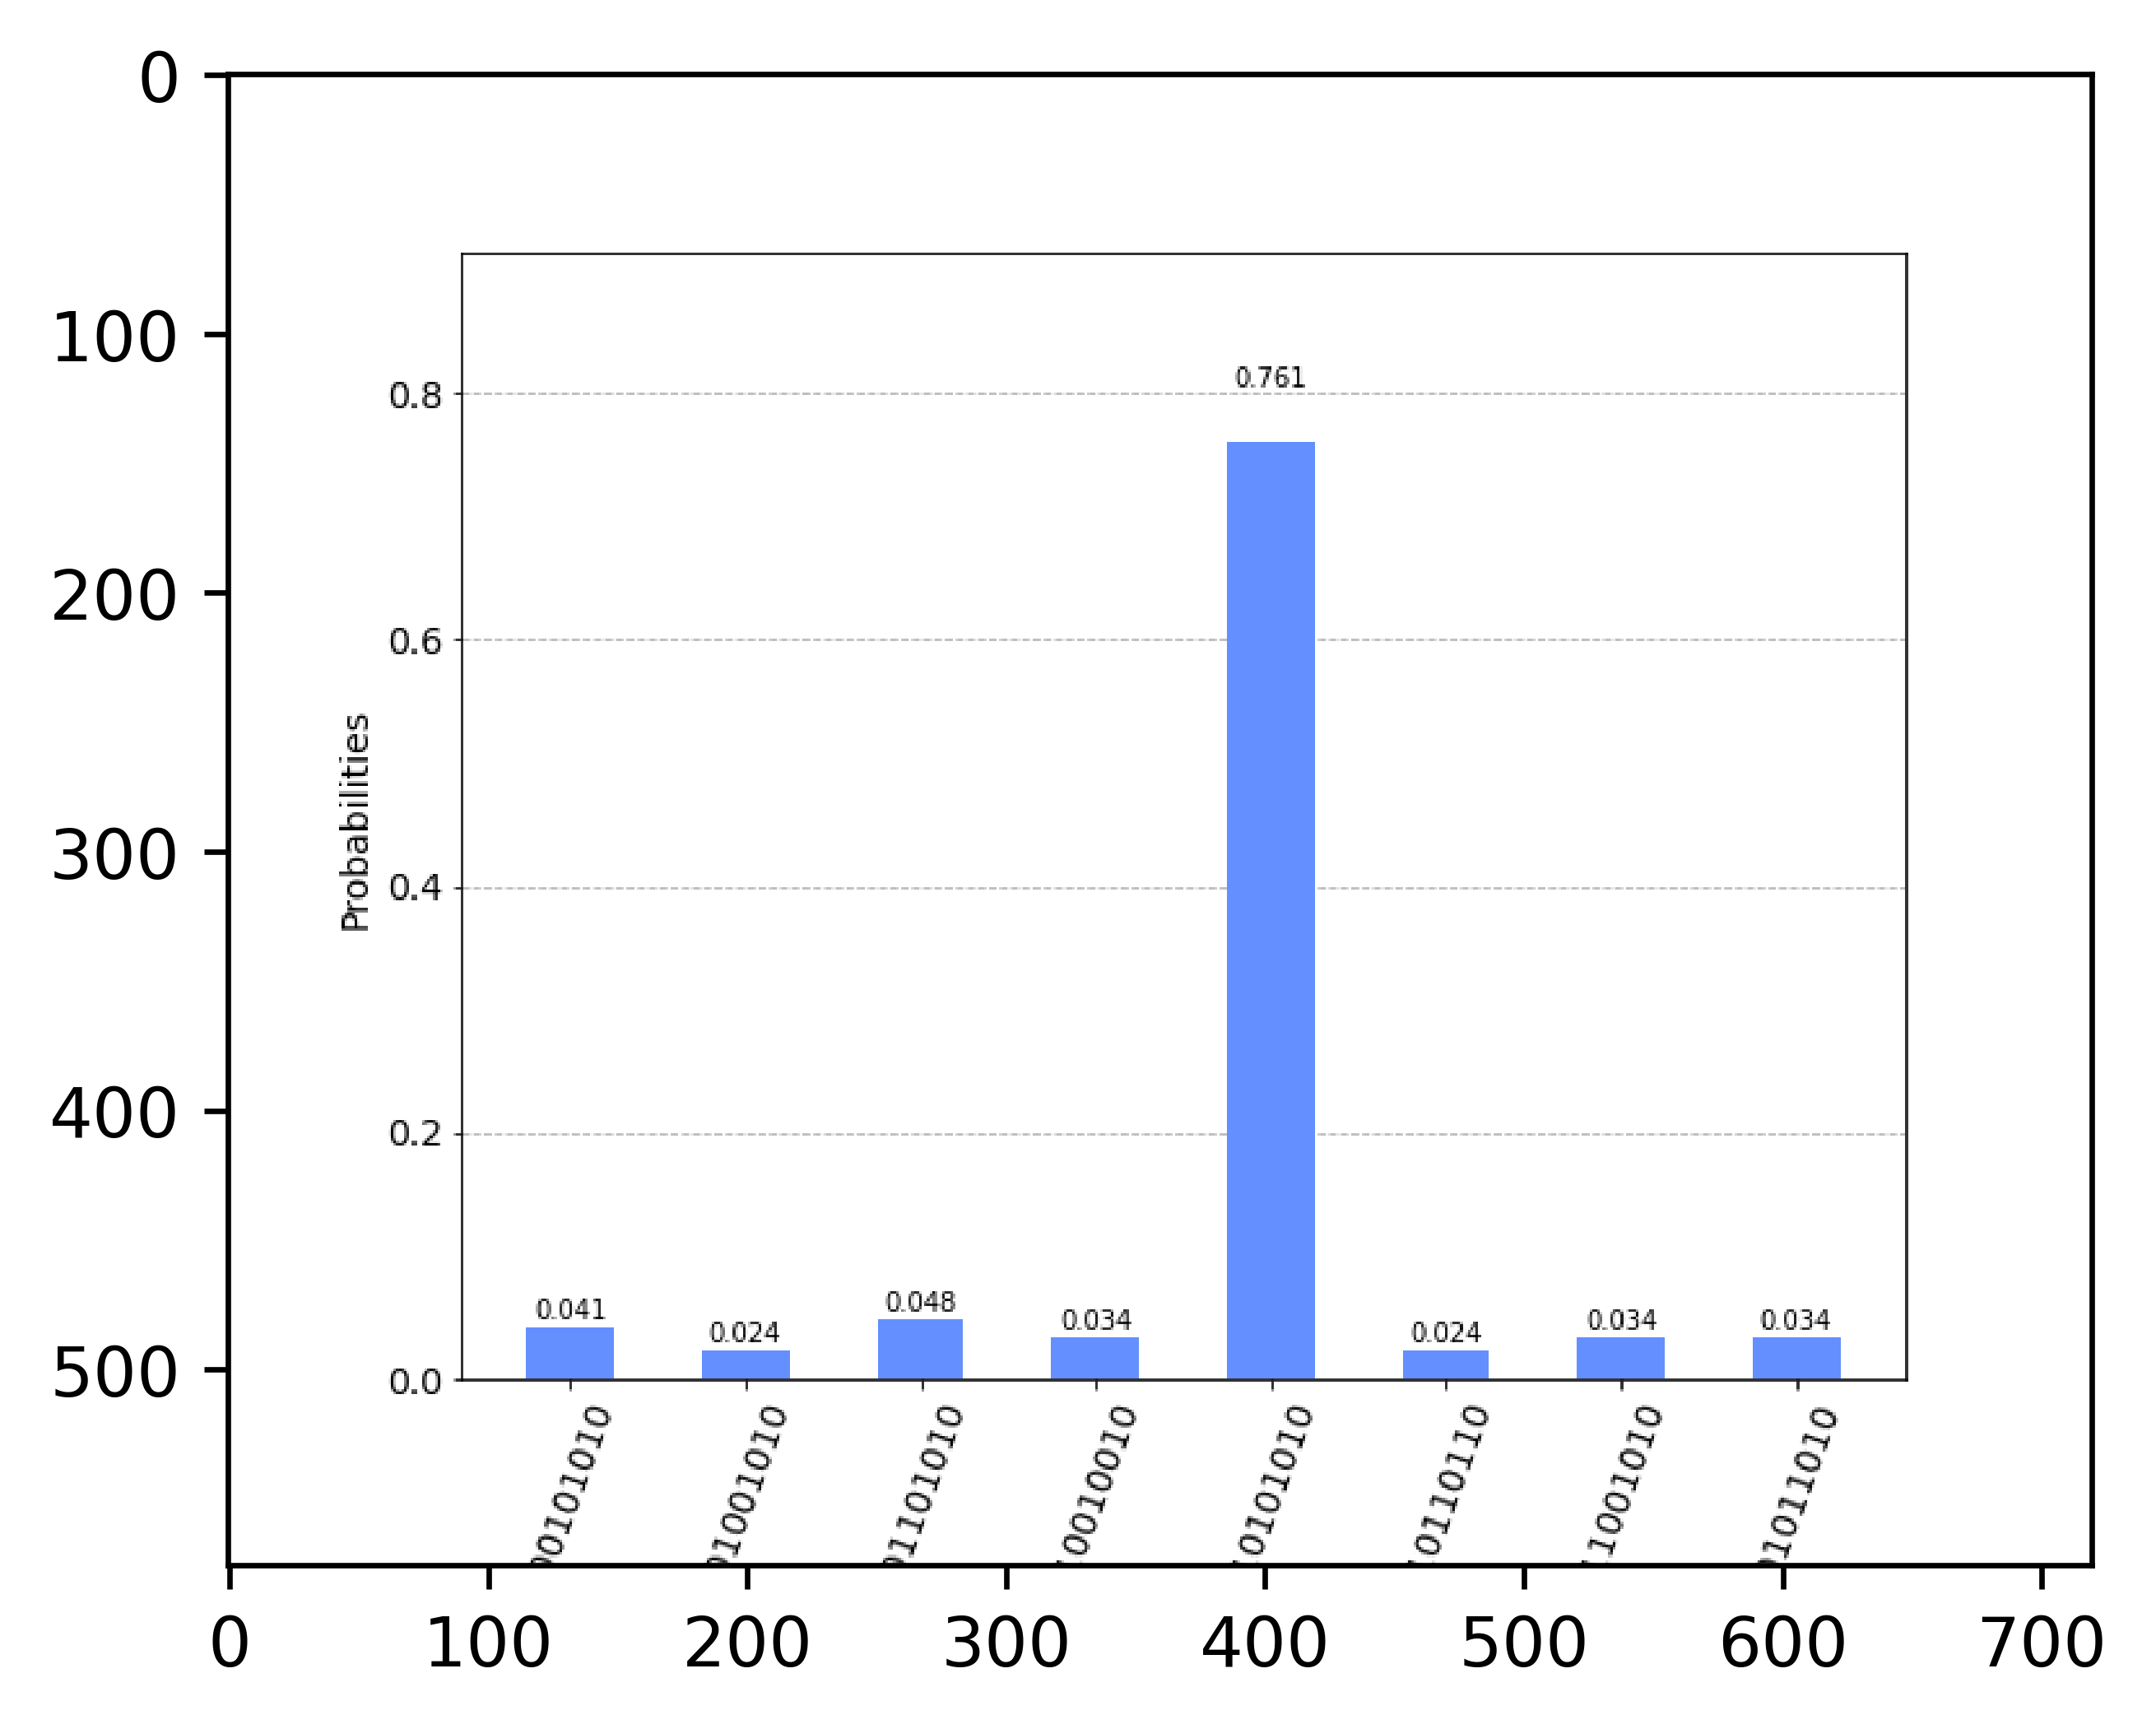

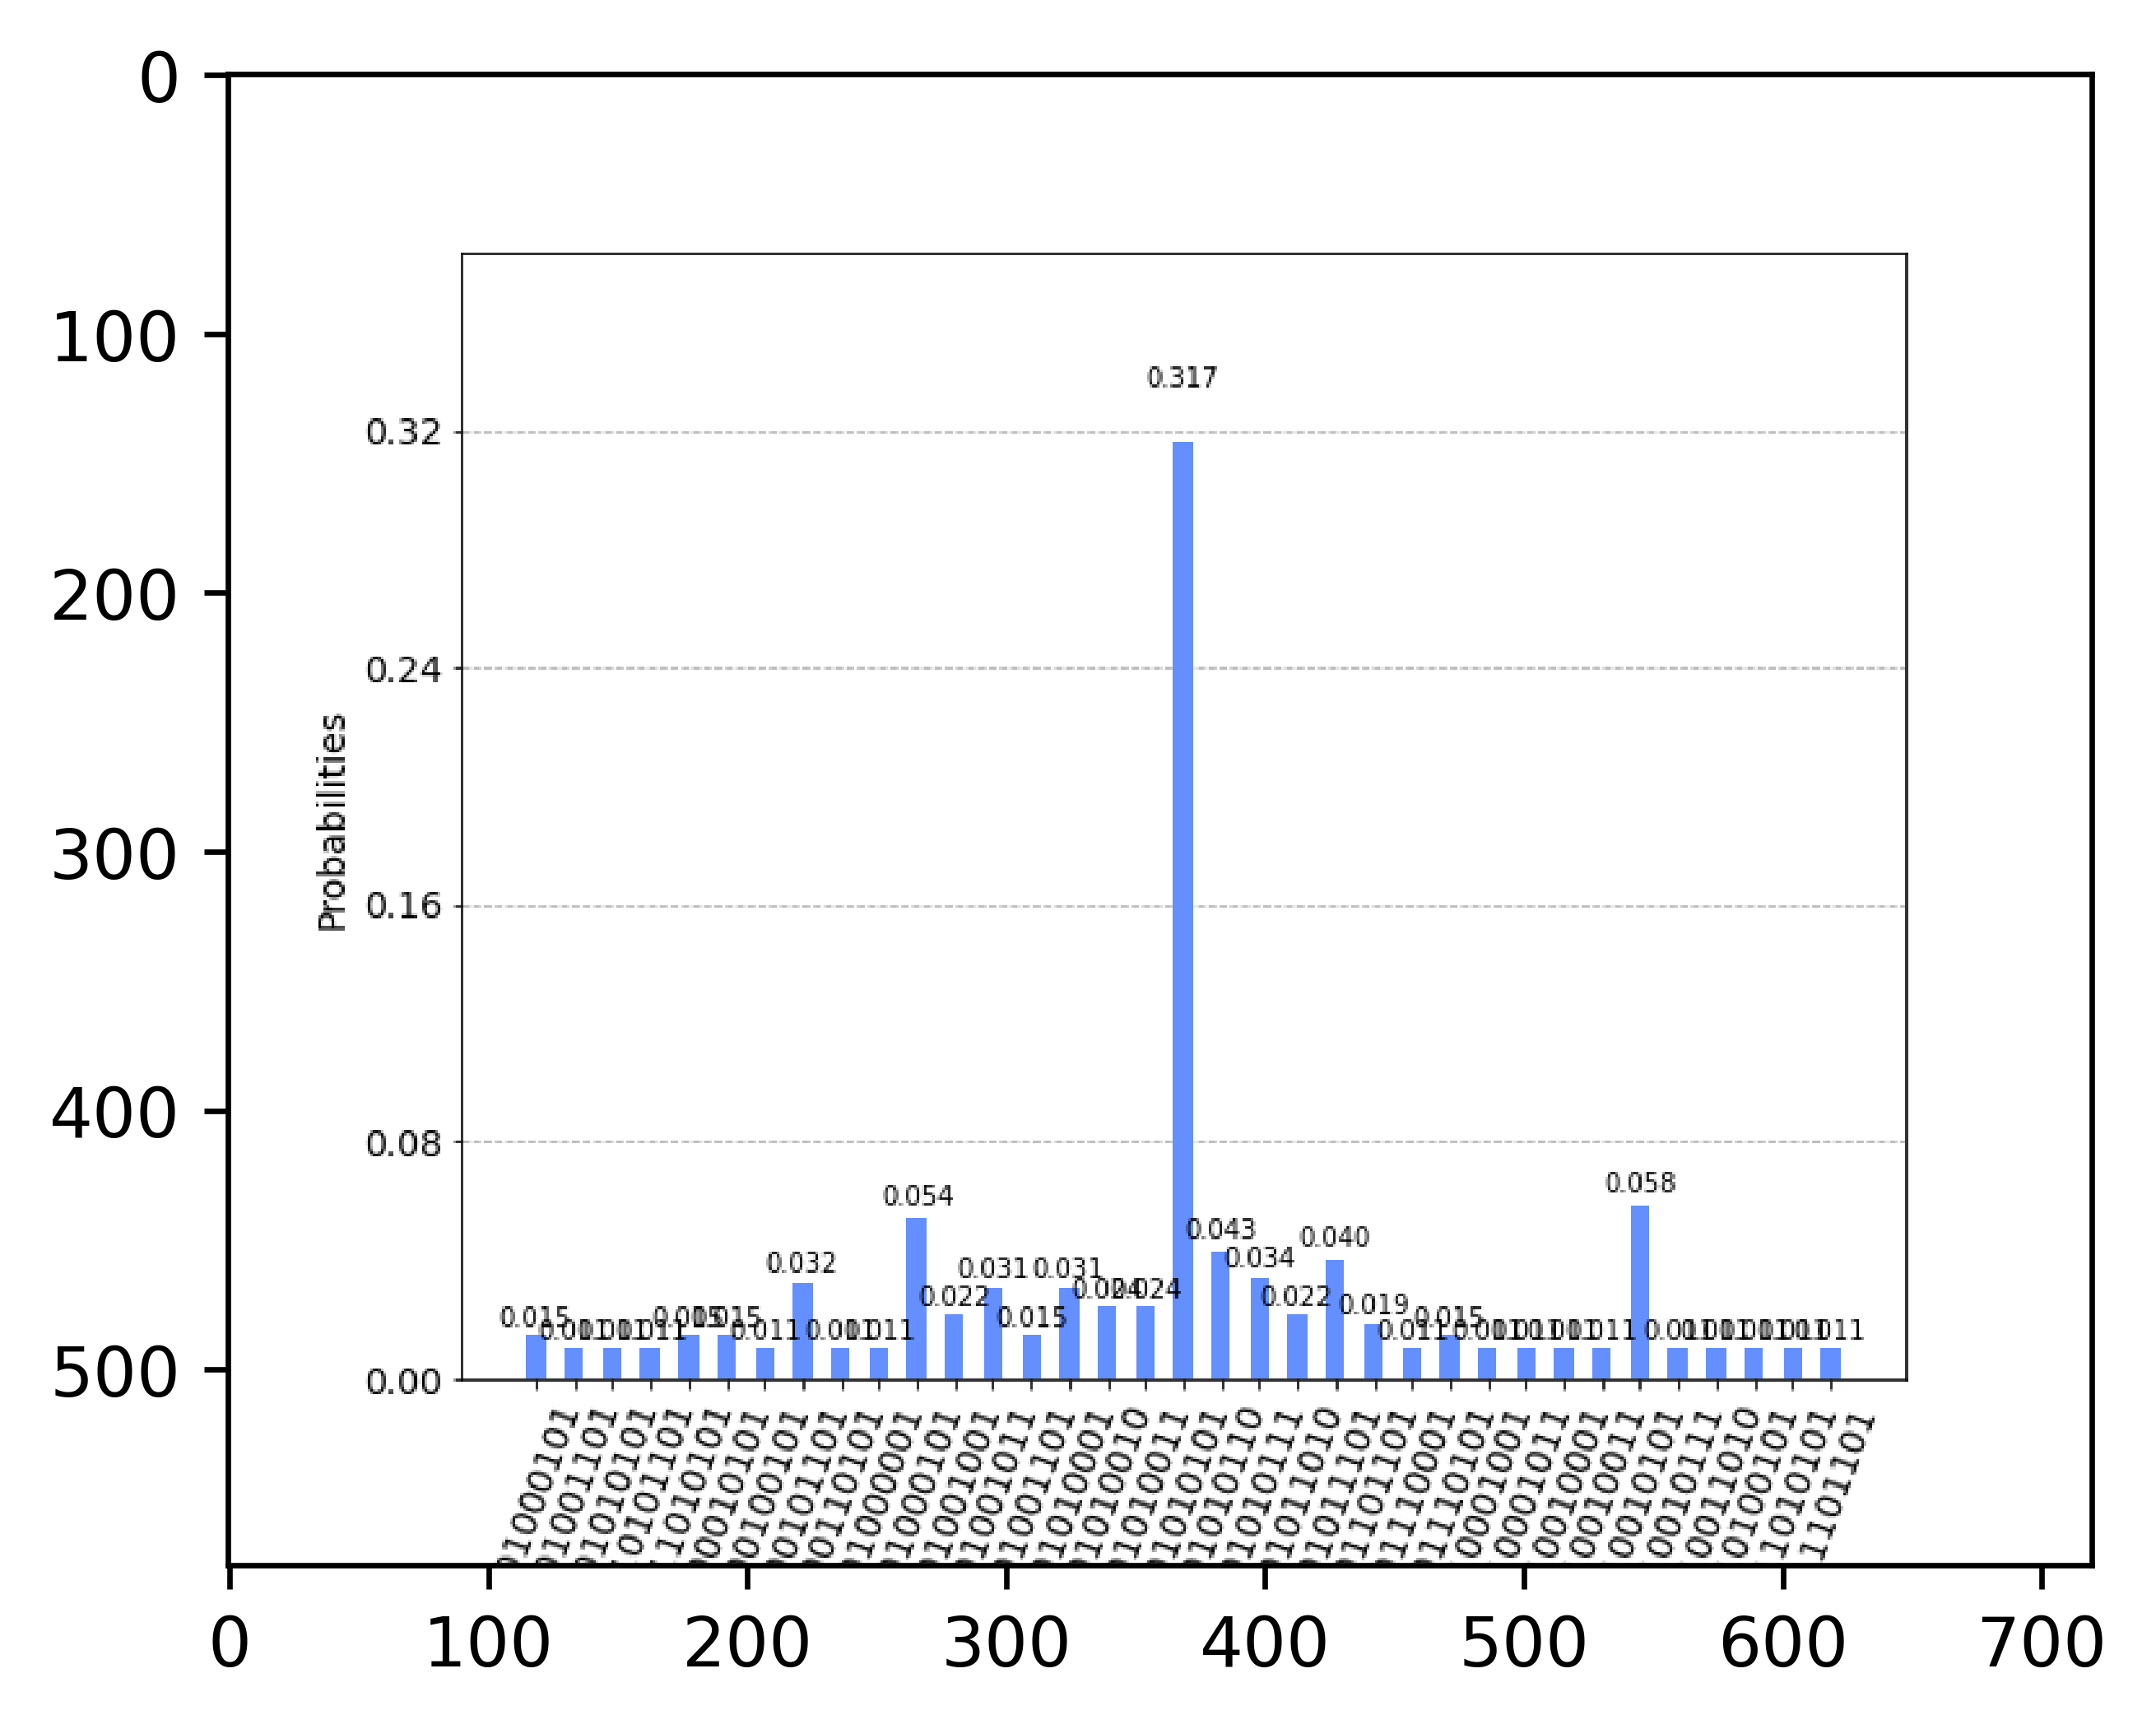

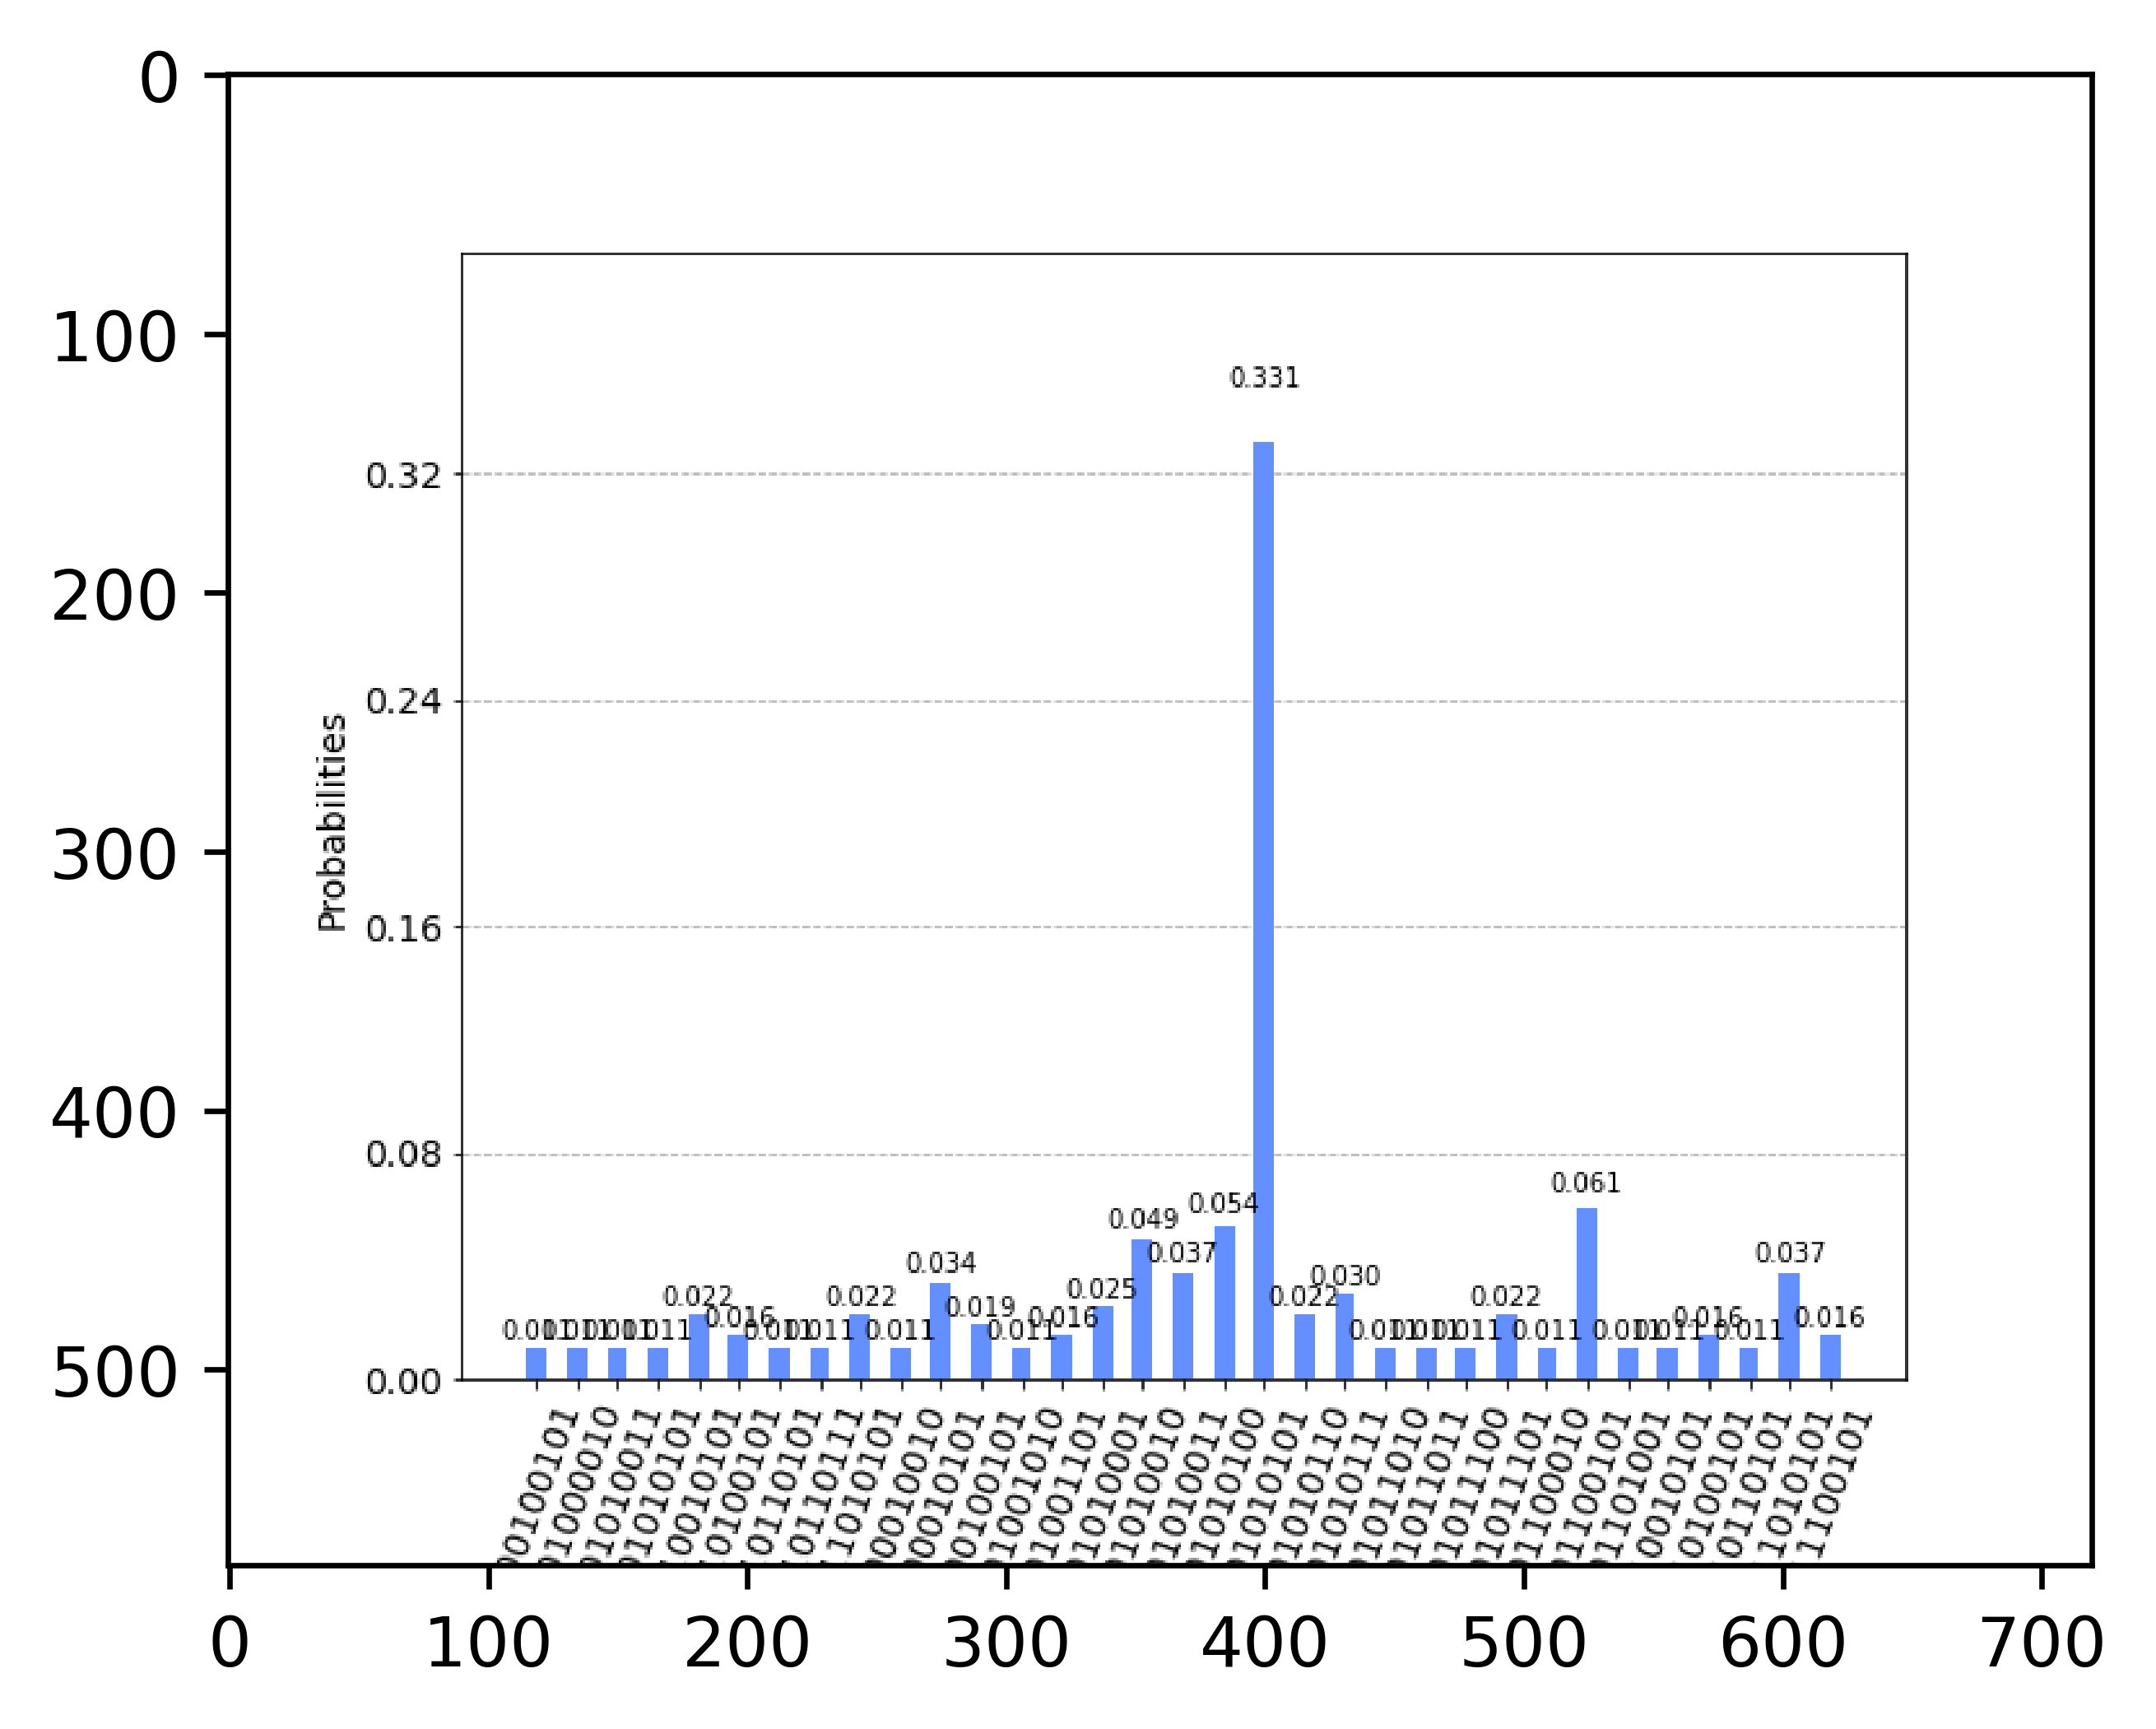

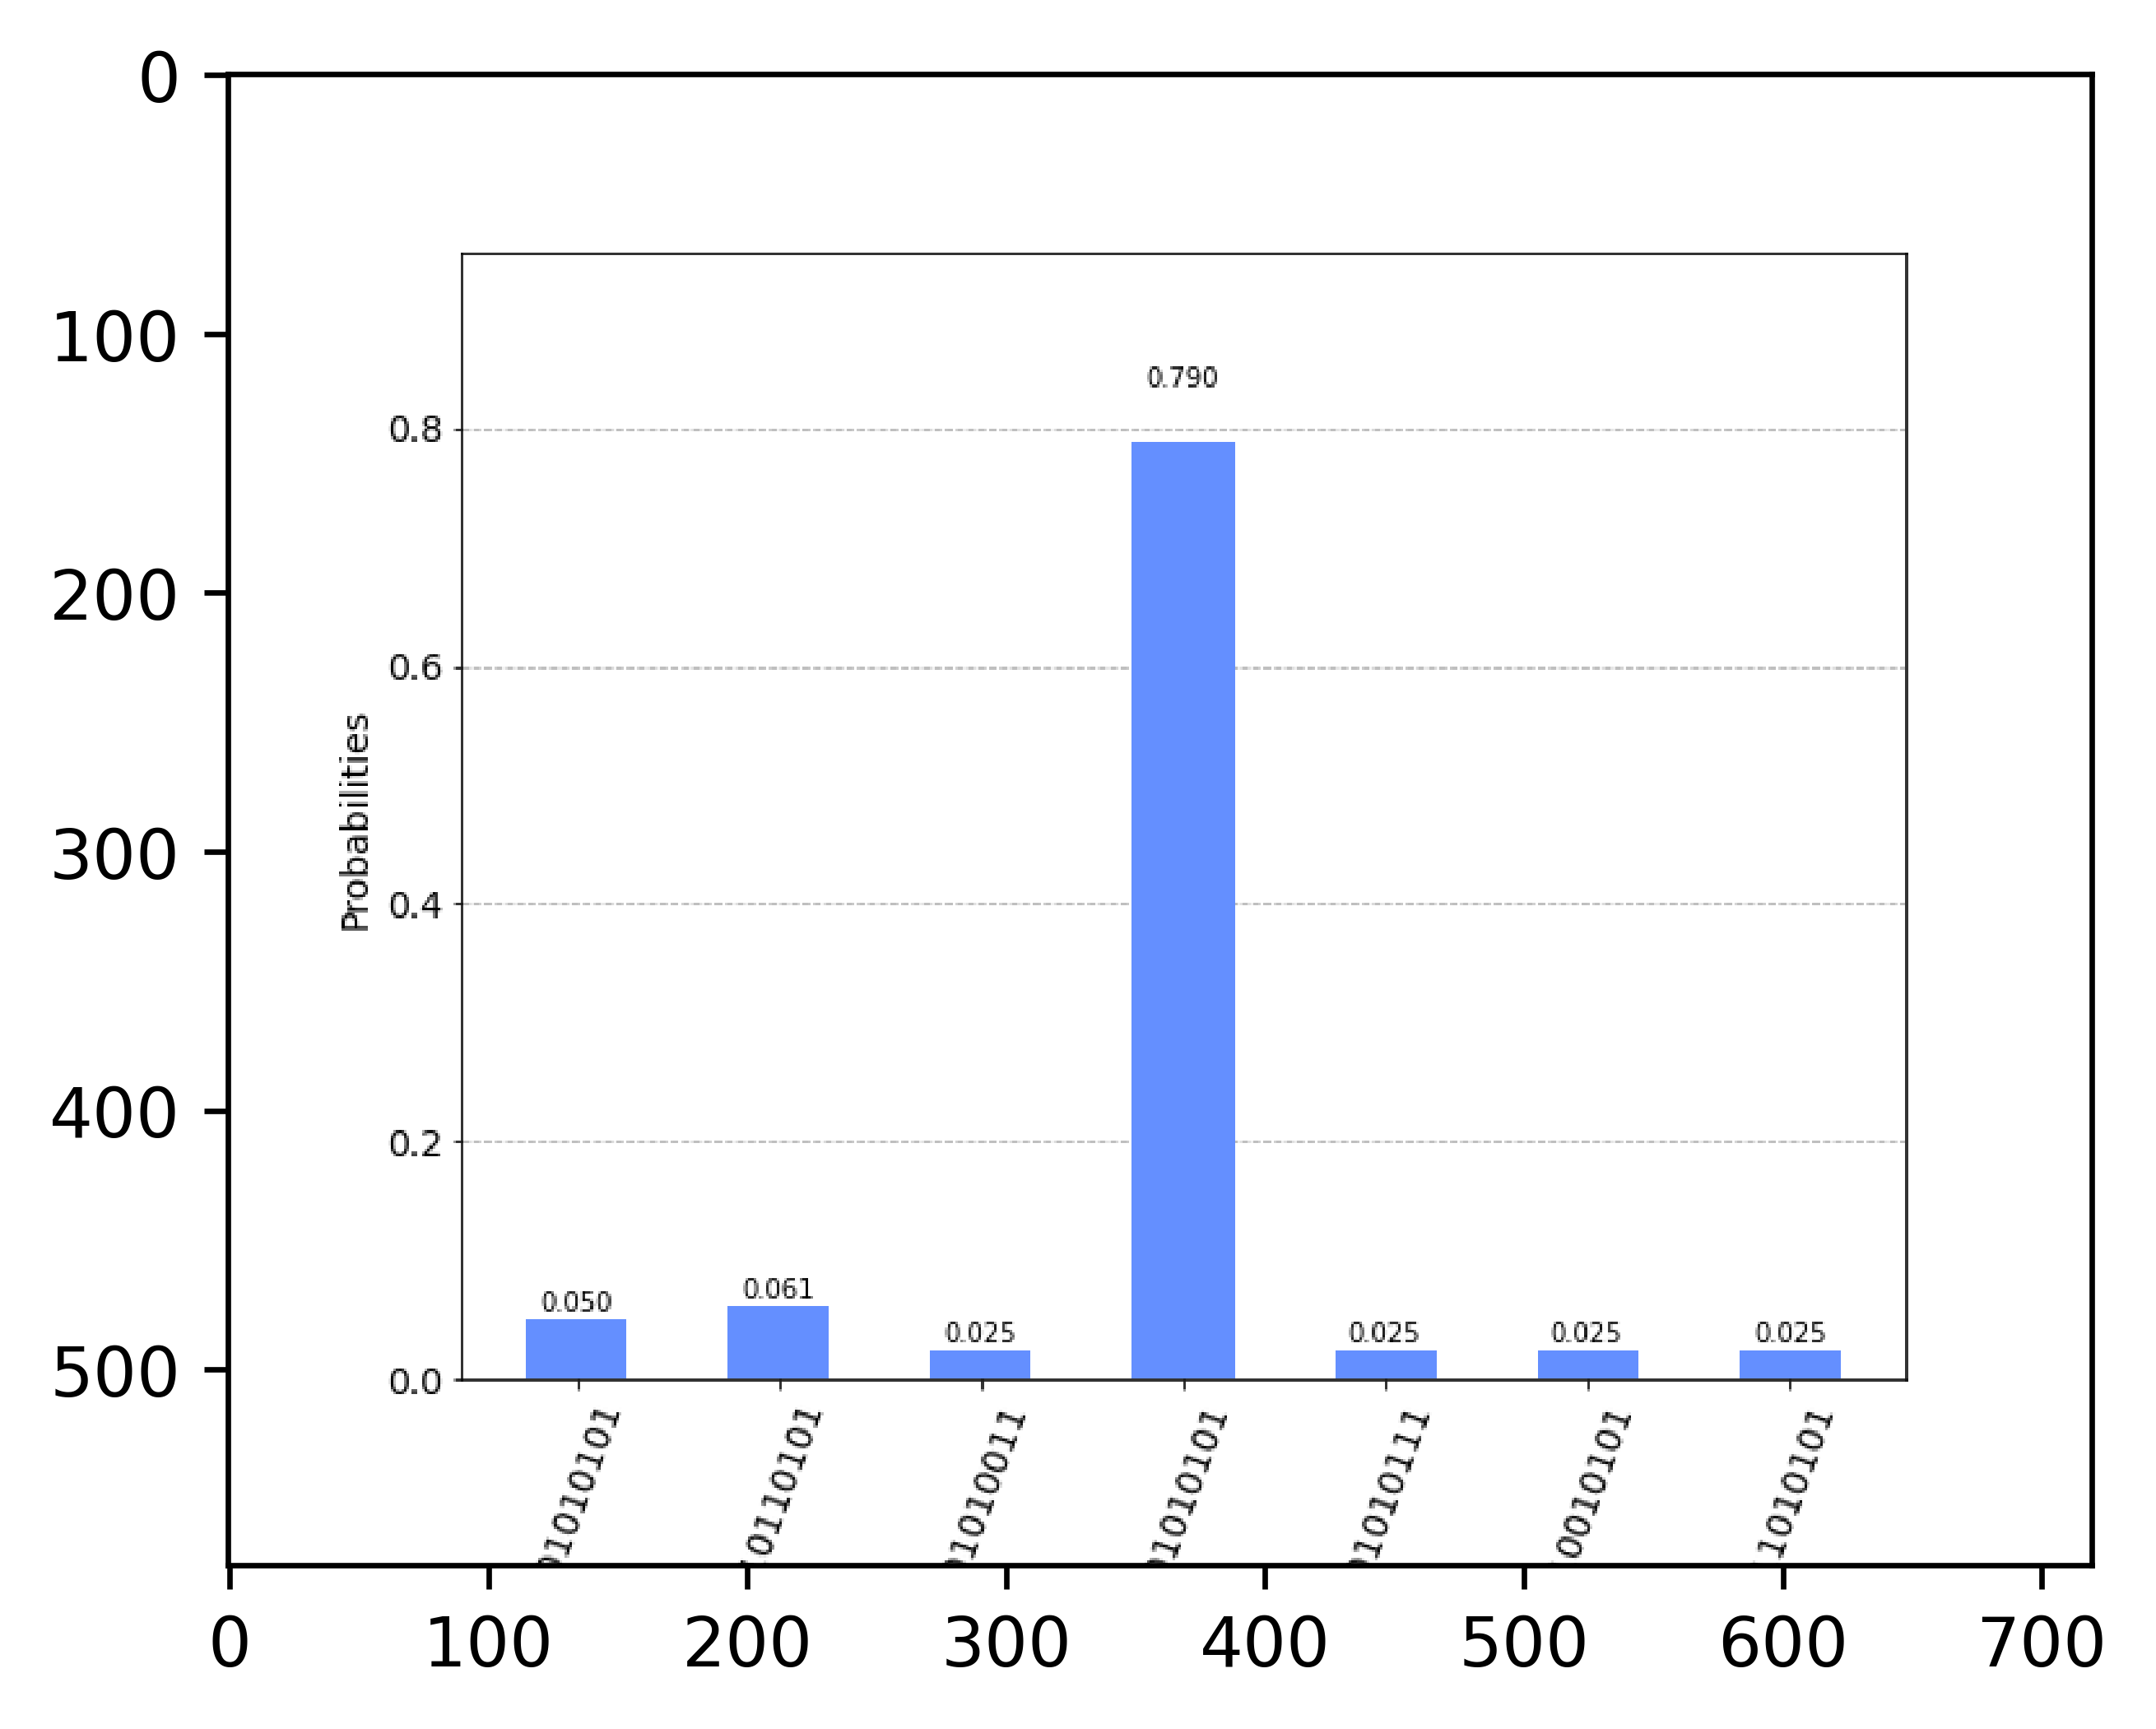

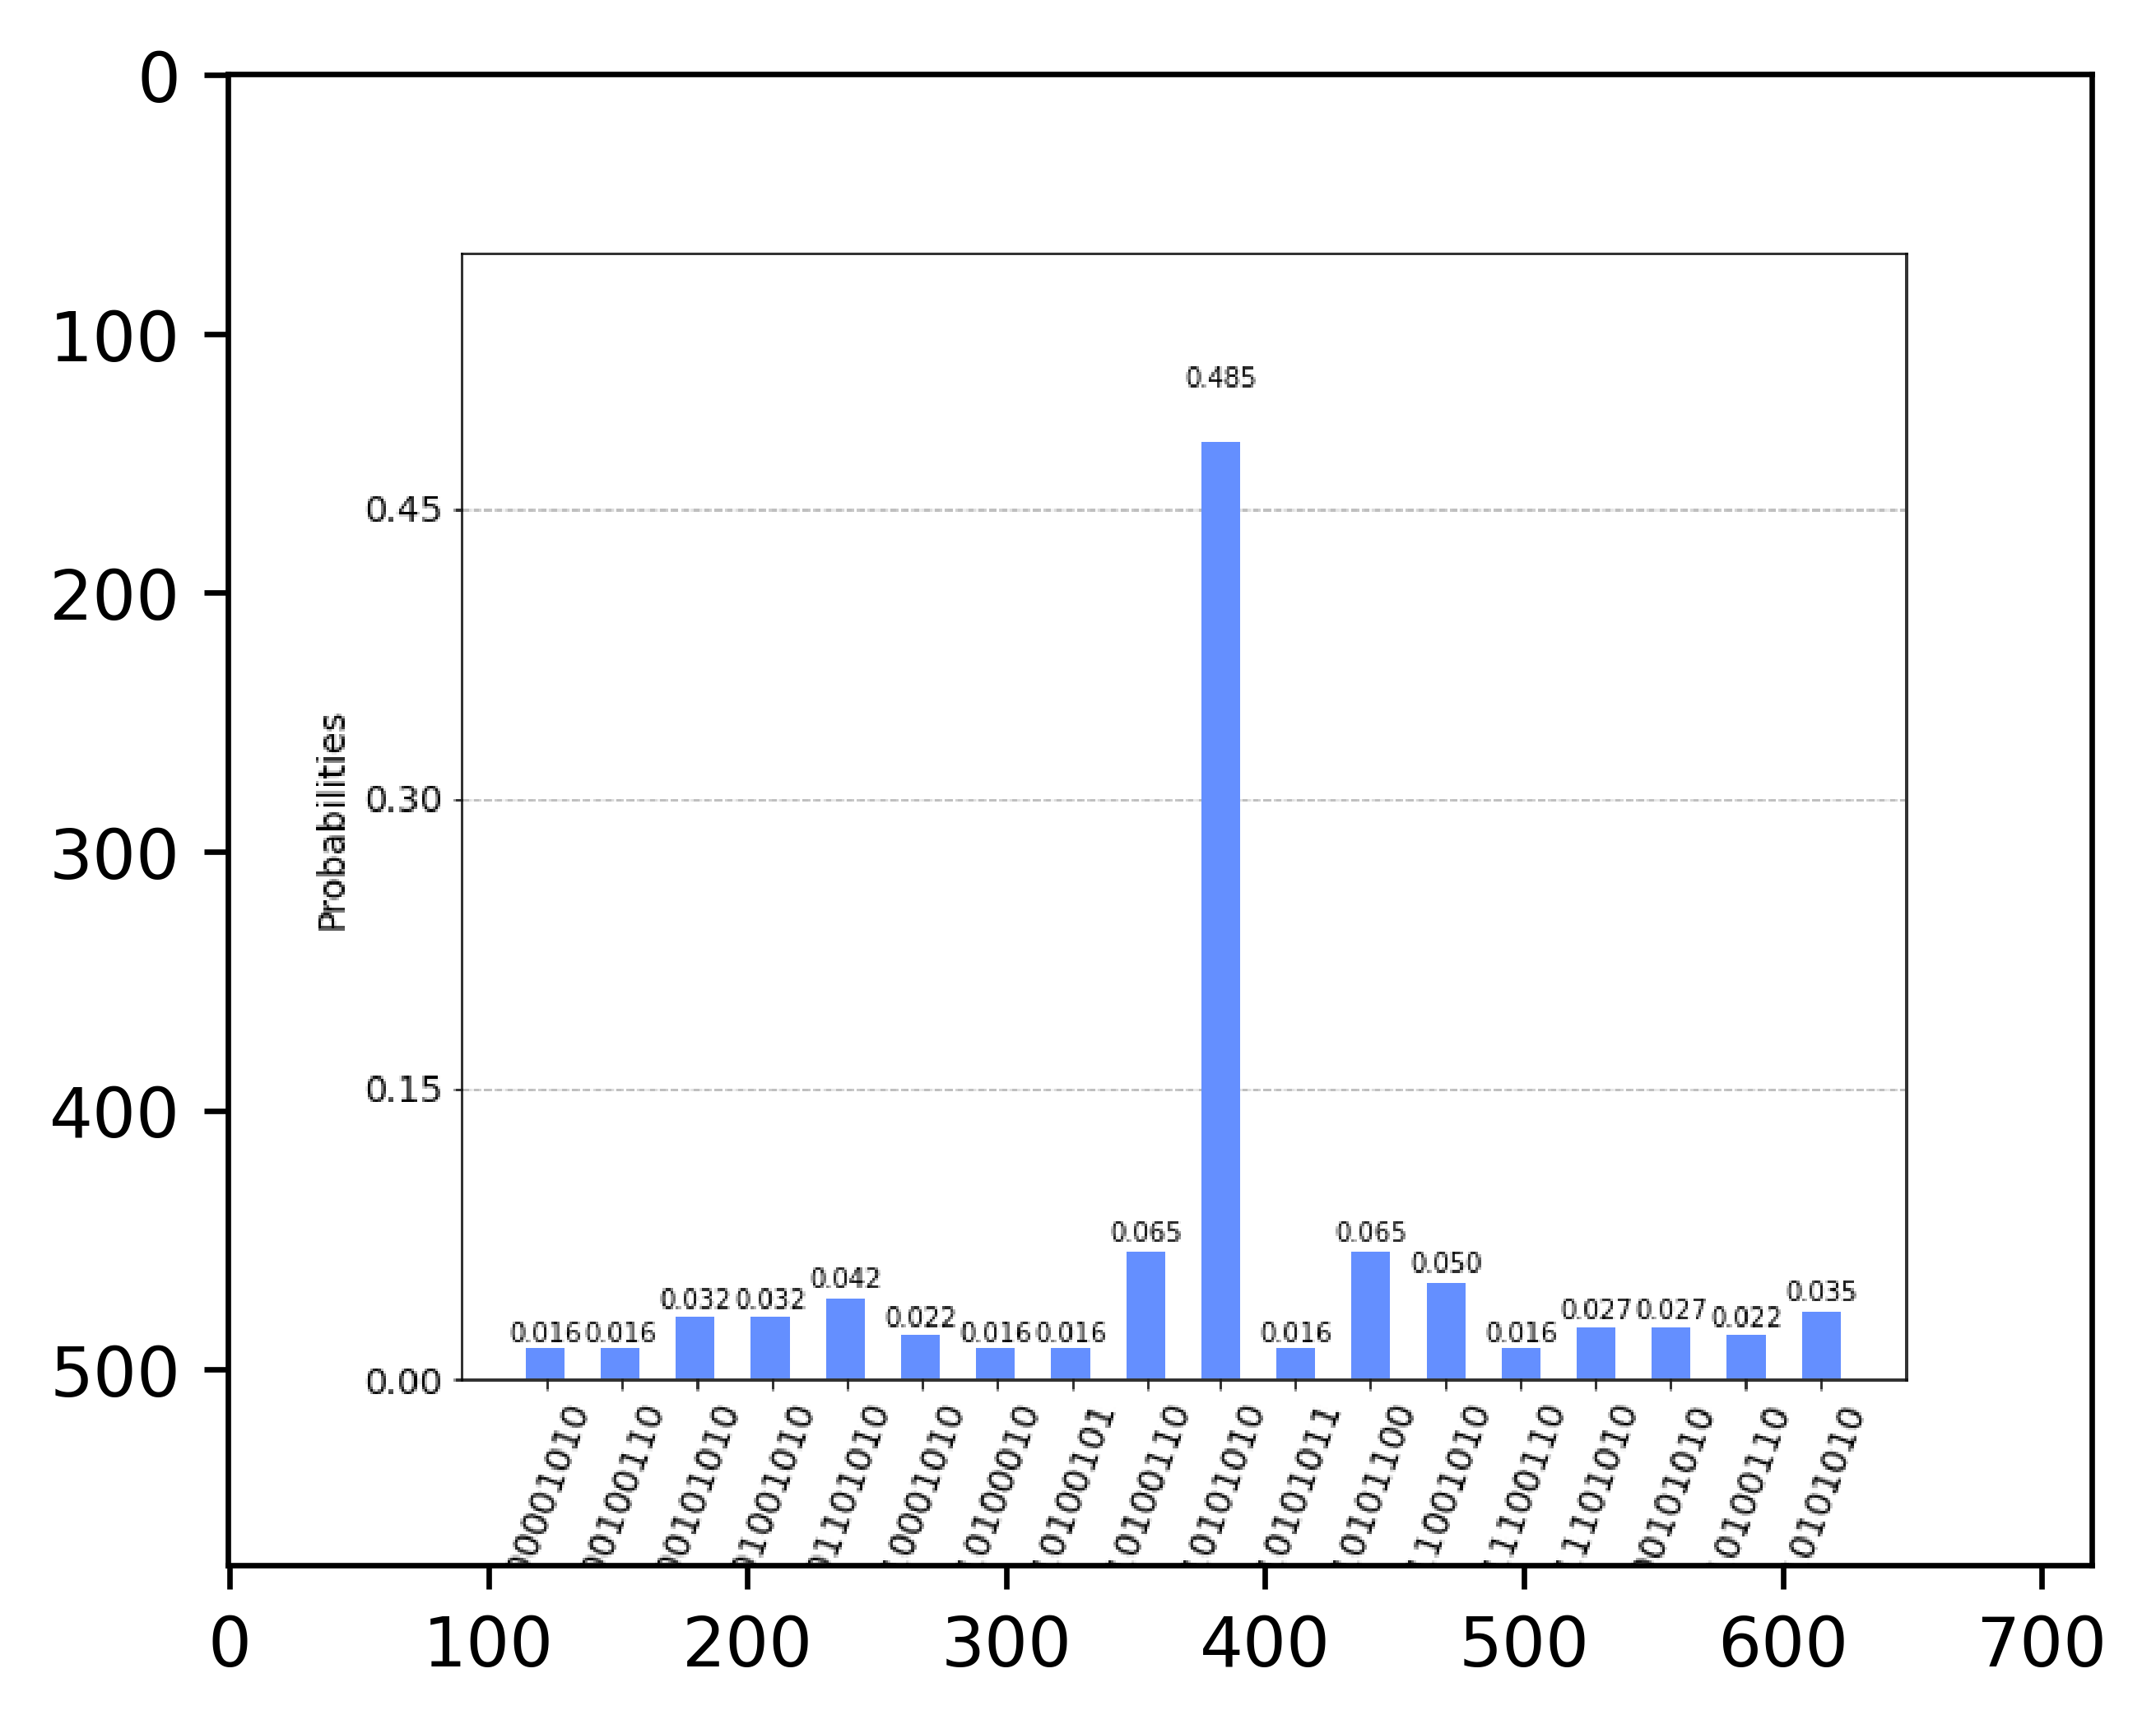

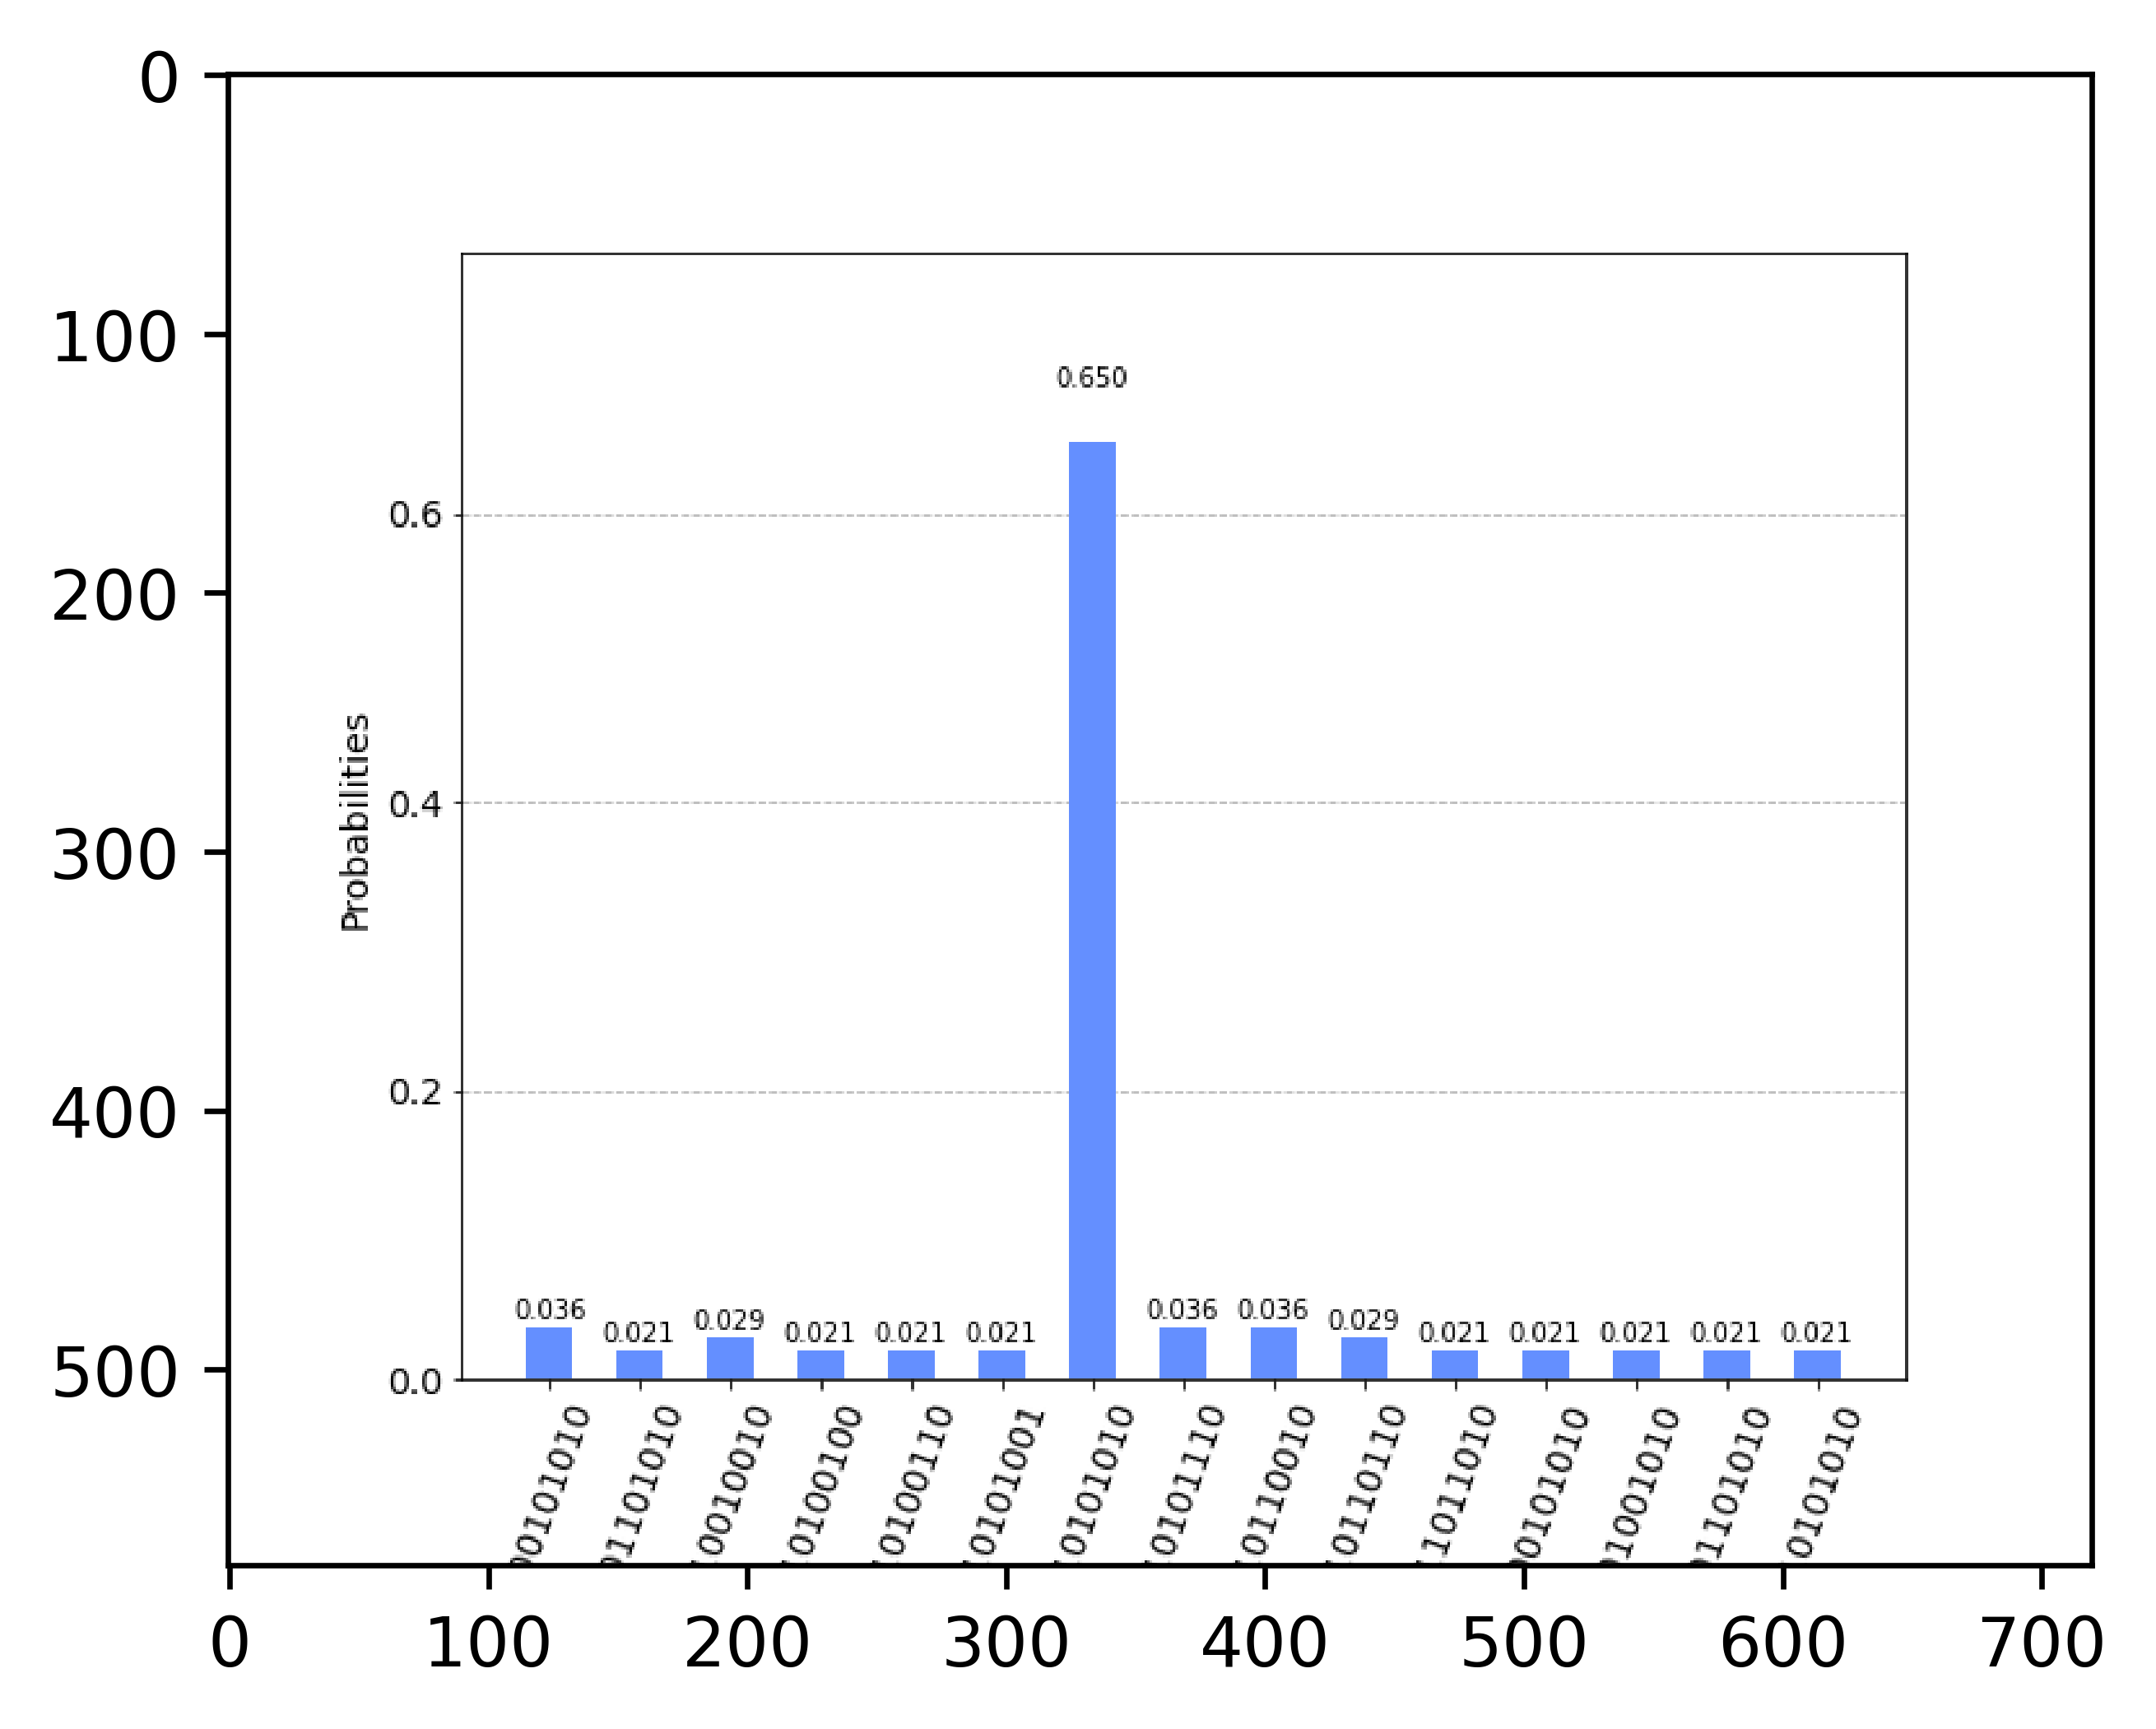

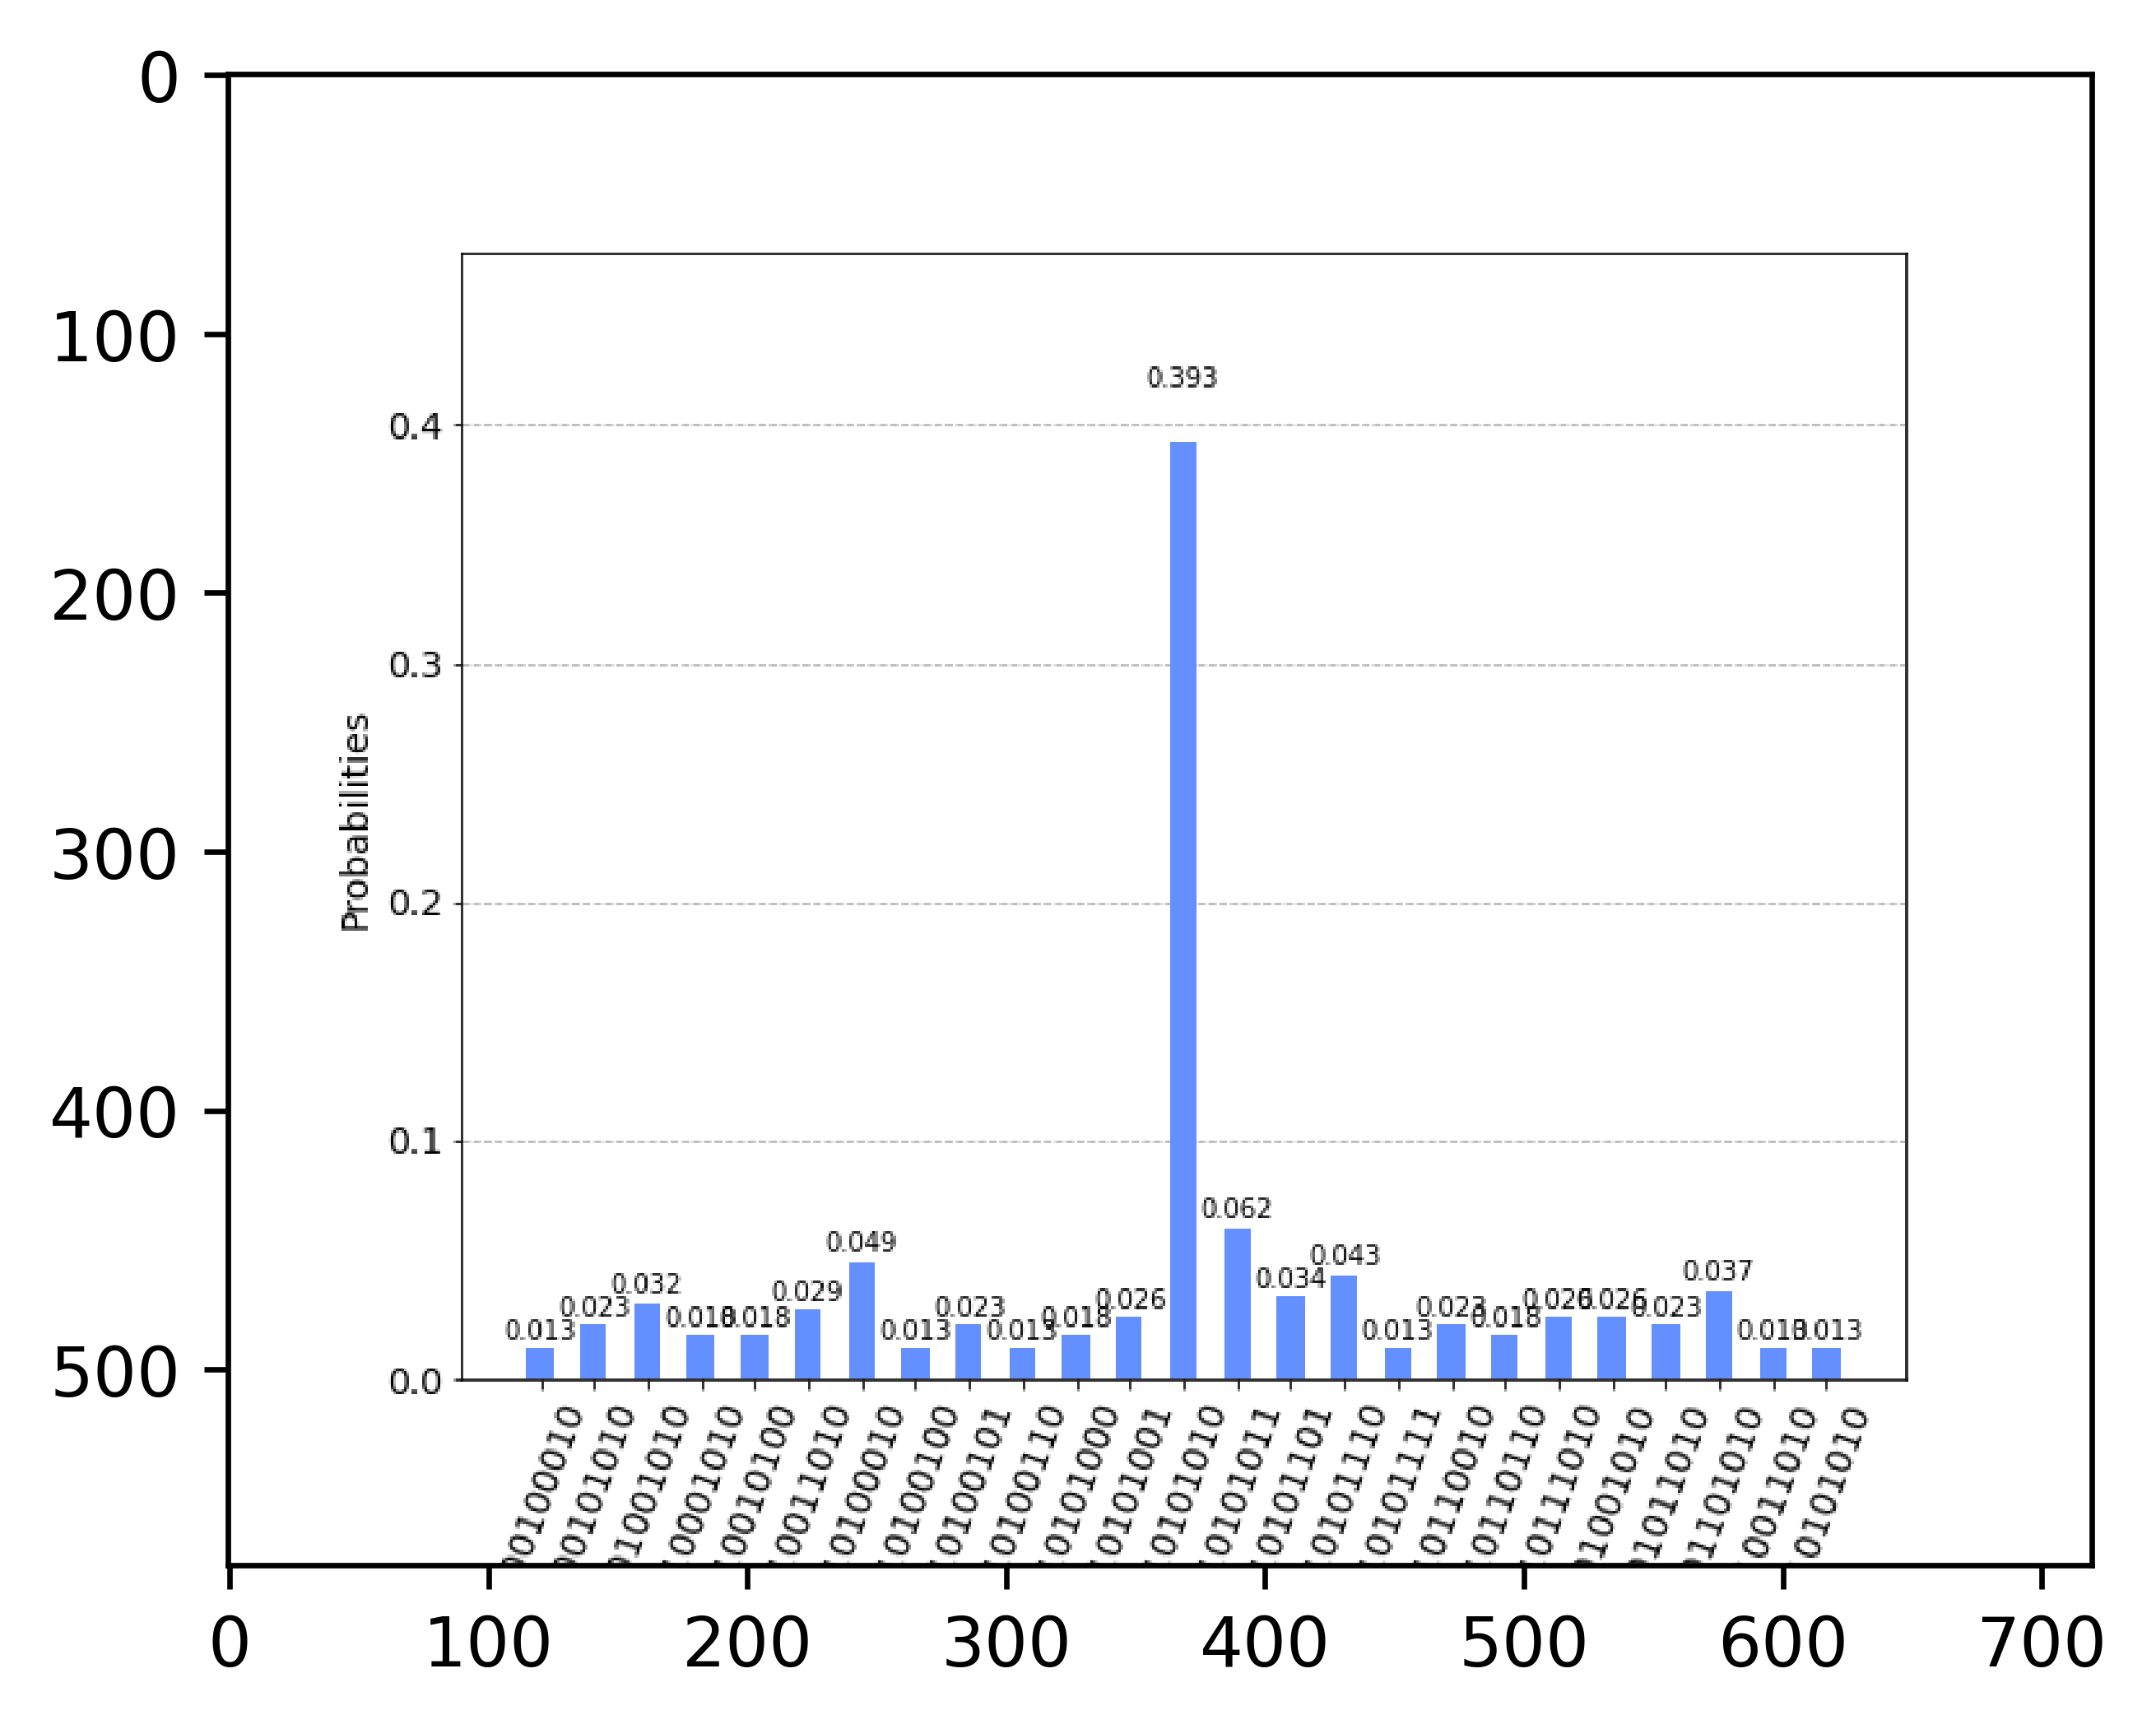

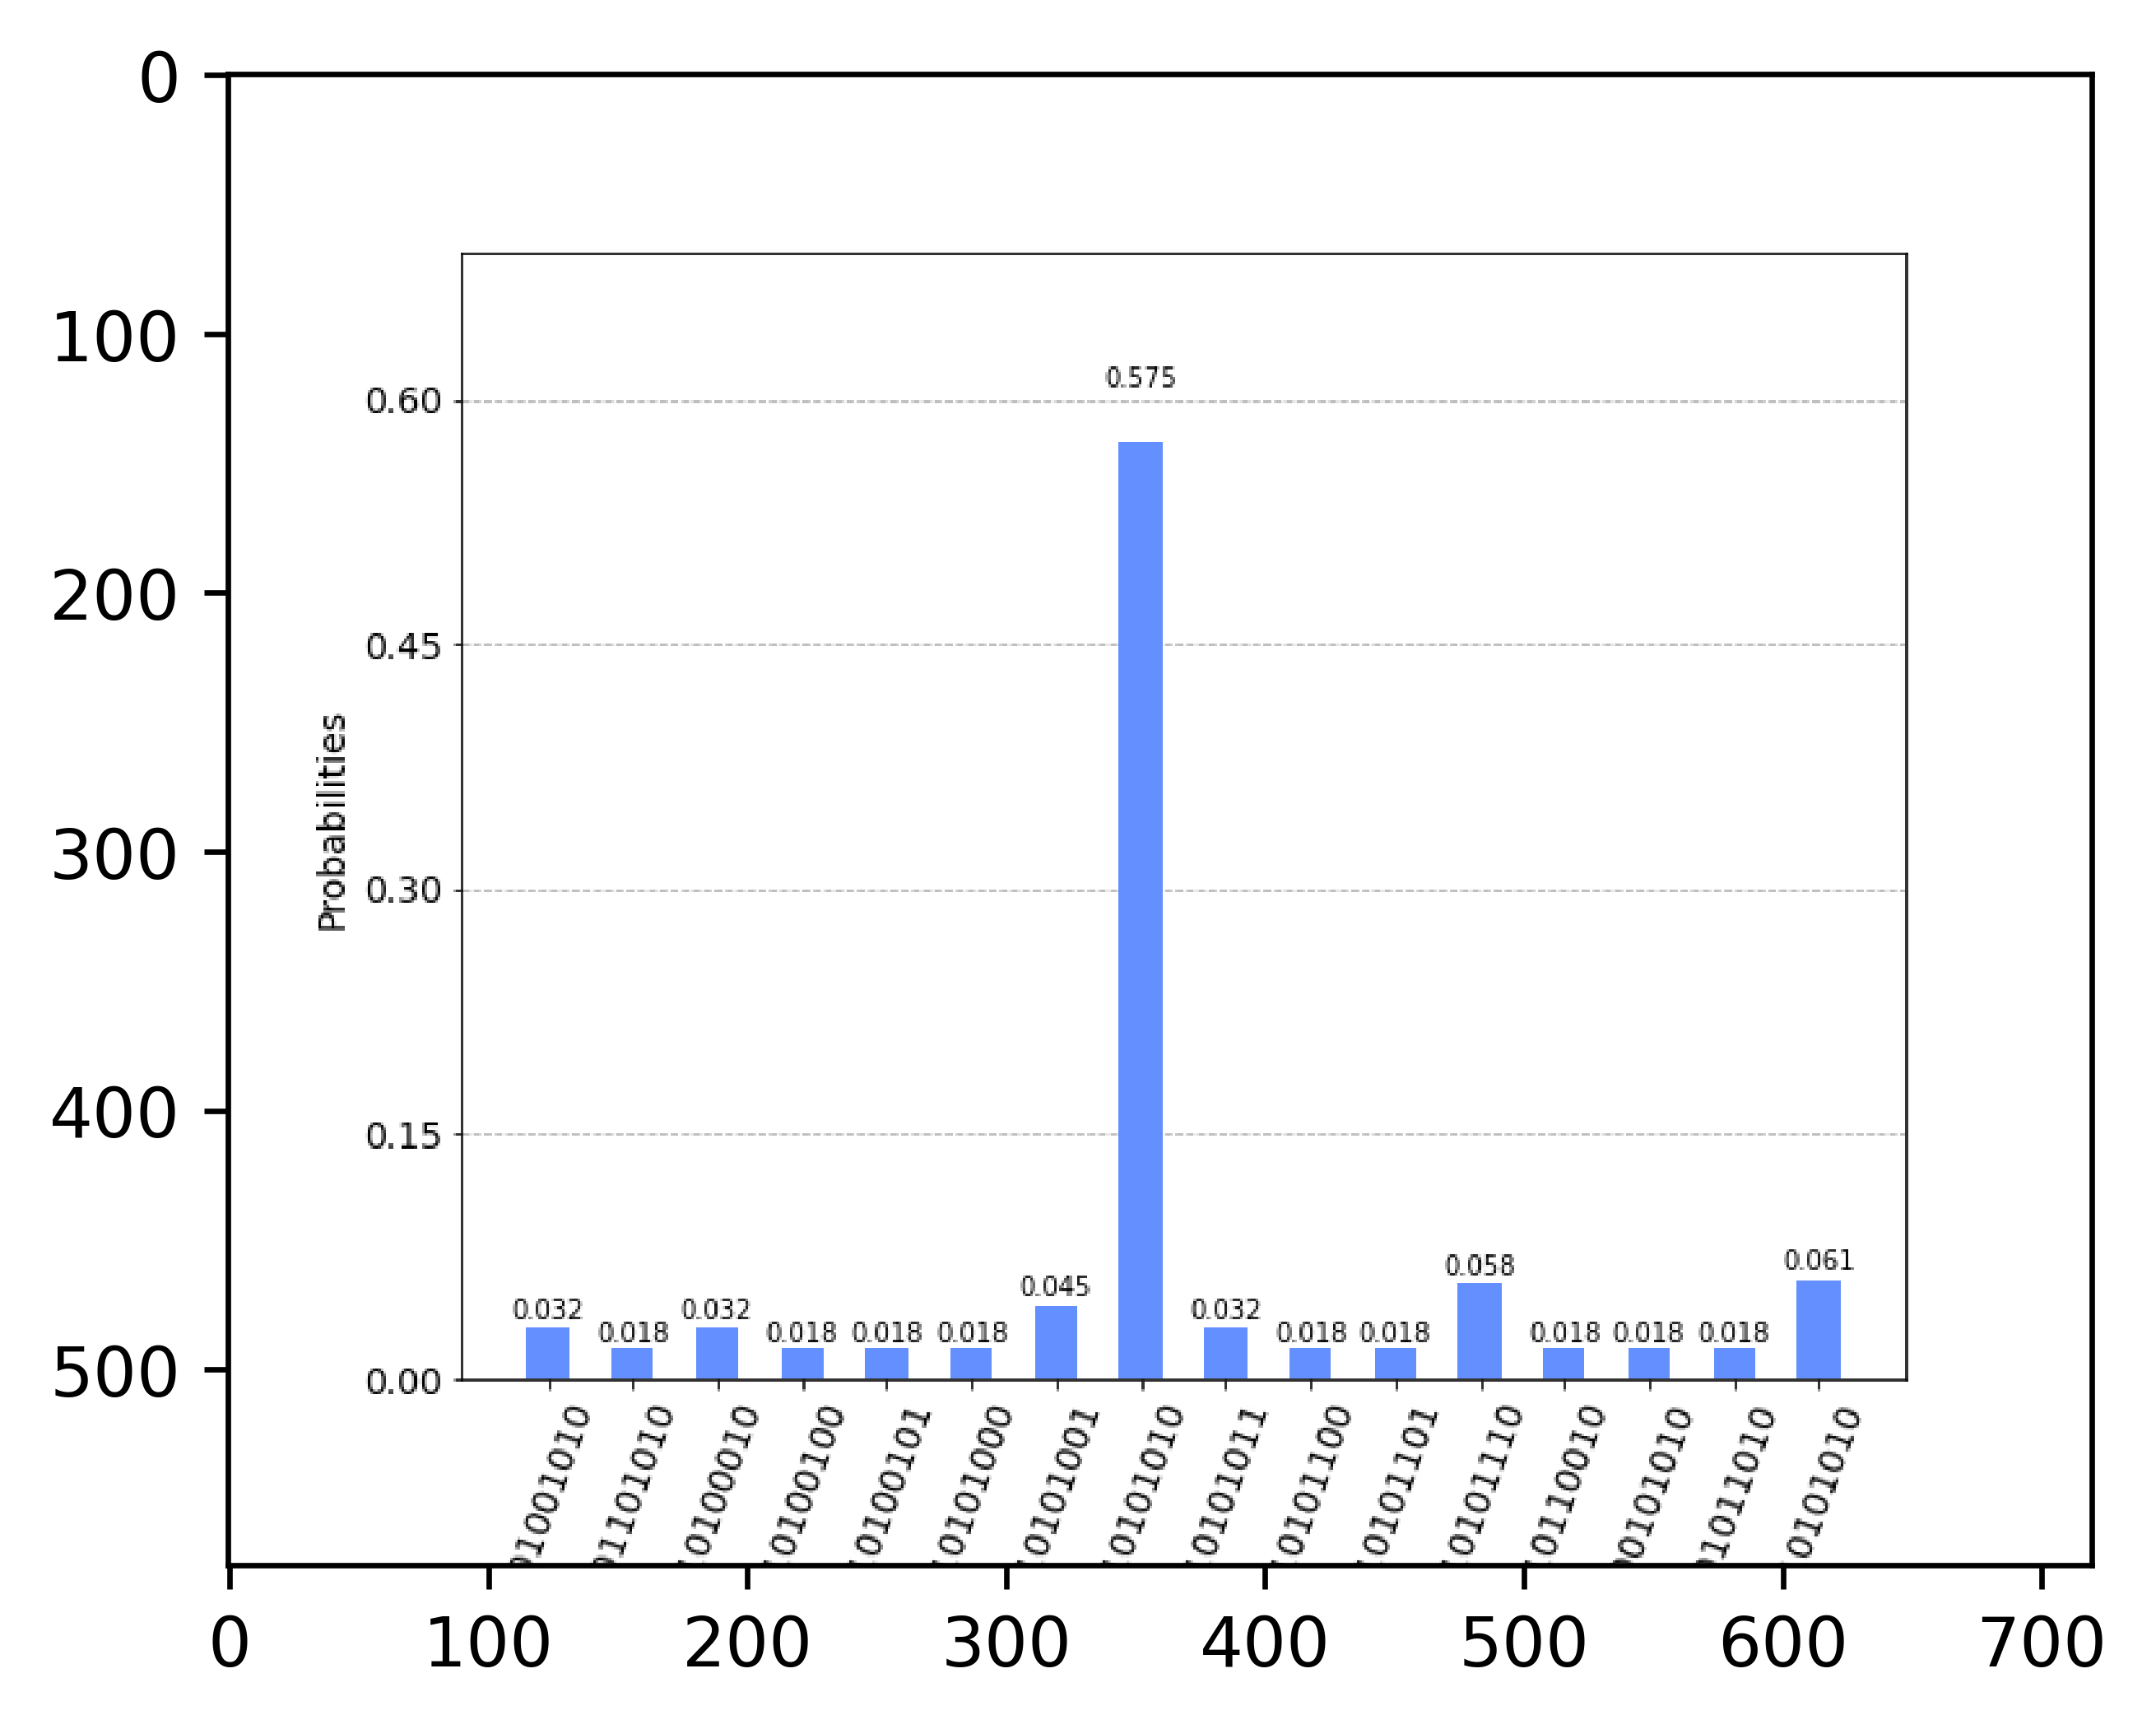

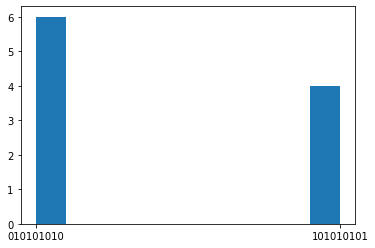

In [60]:
from PIL import Image
# running multiple trials:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run vqe multiple times:
m = 10
results = []
high_probs = []
for i in range(m):
    result = vqe.compute_minimum_eigenvalue(qubitOp)
    x = max_cut.sample_most_likely(result.eigenstate)
    qubit_string = ""
    for j in x:
        qubit_string += str(j)
    high_probs.append(qubit_string)
    print("Trial " + str(i) + ":")
    print("energy:", result.eigenvalue.real)
    print("time:", result.optimizer_time)
    print("max-cut objective:", result.eigenvalue.real + offset)
    print("solution:", x)
    print("solution objective:", qp.objective.evaluate(x))
    plot_histogram(result.eigenstate, figsize = (10,8), bar_labels = True, filename = "/Users/youfuqian/My Drive/College/#Research/3.MaxCut and statistical physics/3x3hists/trial" + str(i))
    fig = Image.open("/Users/youfuqian/My Drive/College/#Research/3.MaxCut and statistical physics/3x3hists/trial" + str(i) + ".png")
    plt.figure(dpi = 600)
    plt.imshow(fig)
    print()
    results.append(result)

# prob of each result:
plt.figure()
plt.hist(high_probs, density = True)
plt.show()

objective function value: 12.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=0.0, x_8=1.0
status: SUCCESS


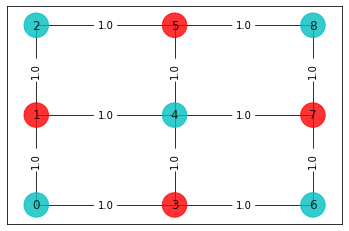

In [61]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)